In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_preprocess(path):
    df = pd.read_csv(path)

    # 1) Filtrar dados completos e relevantes
    df = df[df['datacompleteness'] == 'complete']
    df = df[df['participantid'].isin([100, 200])]

    # 2) Criar variáveis de diferença (10 e 15 min)
    df['golddiffat10'] = df['goldat10'] - df['opp_goldat10']
    df['xpdiffat10'] = df['xpat10'] - df['opp_xpat10']
    df['csdiffat10'] = df['csat10'] - df['opp_csat10']

    df['golddiffat15'] = df['goldat15'] - df['opp_goldat15']
    df['xpdiffat15'] = df['xpat15'] - df['opp_xpat15']
    df['csdiffat15'] = df['csat15'] - df['opp_csat15']

    # 3) (Opcional) Remover colunas absolutas para reduzir multicolinearidade
    drop_cols = [
        'goldat10', 'opp_goldat10', 'xpat10', 'opp_xpat10', 'csat10', 'opp_csat10',
        'goldat15', 'opp_goldat15', 'xpat15', 'opp_xpat15', 'csat15', 'opp_csat15'
    ]
    df.drop(columns=drop_cols, inplace=True, errors='ignore')

    # 4) Codificar 'side' e variáveis binárias
    df['side'] = df['side'].str.strip().str.capitalize().map({'Red': 0, 'Blue': 1})
    binary_vars = ['firstblood', 'firstdragon', 'firstherald', 'firsttower', 'firstbaron']
    df[binary_vars] = df[binary_vars].astype(int)

    return df

df = load_and_preprocess('lol.csv')


<ipython-input-1-cdb92ea5d799>:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [ ]:
!pip install category-encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.0 MB/s eta 0:00:00


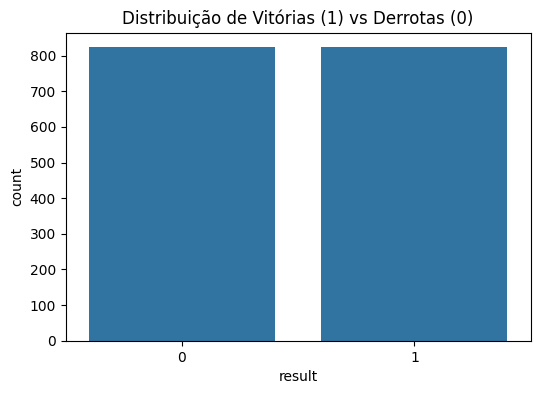

Proporção de Vitórias: 50.00%


In [ ]:
# Distribuição de vitórias/derrotas
plt.figure(figsize=(6,4))
sns.countplot(x='result', data=df)
plt.title('Distribuição de Vitórias (1) vs Derrotas (0)')
plt.show()

print(f"Proporção de Vitórias: {df['result'].mean():.2%}")

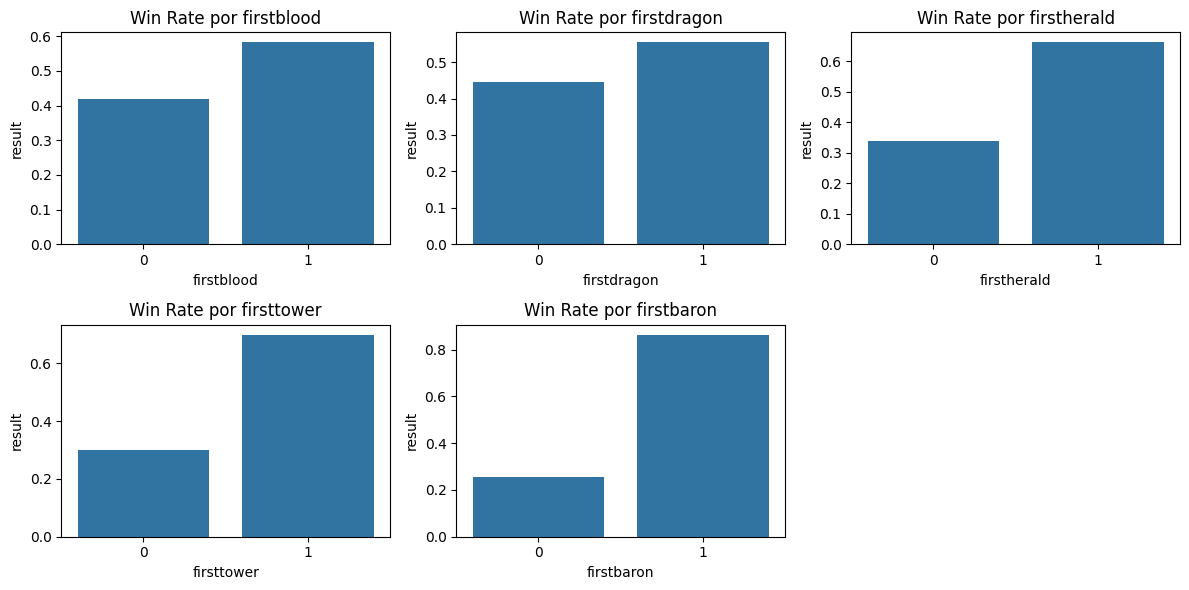

In [ ]:
# Taxa de vitória por first objectives
first_vars = ['firstblood', 'firstdragon', 'firstherald', 'firsttower', 'firstbaron']

plt.figure(figsize=(12,6))
for i, var in enumerate(first_vars, 1):
    plt.subplot(2,3,i)
    sns.barplot(x=var, y='result', data=df, errorbar=None)
    plt.title(f'Win Rate por {var}')
plt.tight_layout()
plt.show()

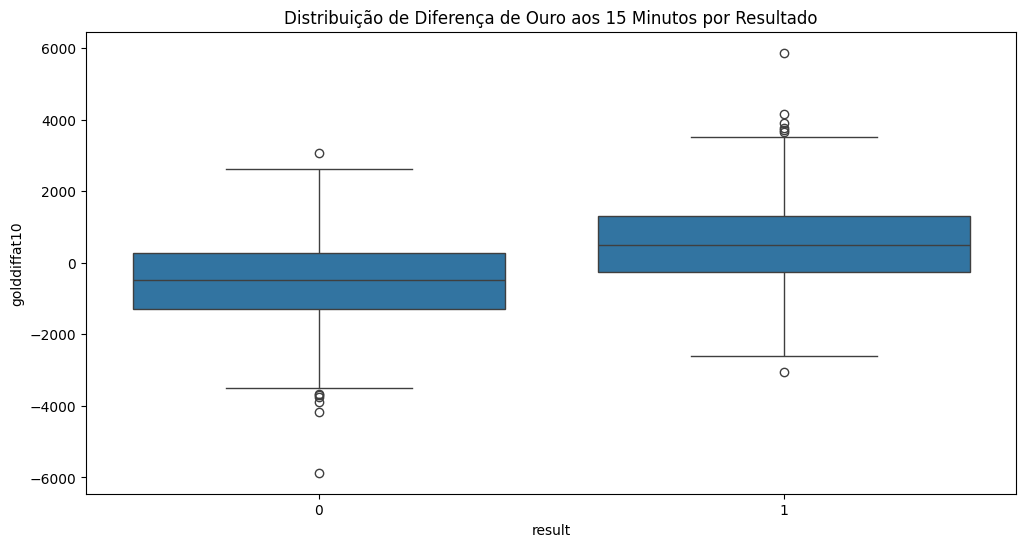

In [ ]:
# Boxplot de diferenças no early game
plt.figure(figsize=(12,6))
sns.boxplot(x='result', y='golddiffat10', data=df)
plt.title('Distribuição de Diferença de Ouro aos 15 Minutos por Resultado', fontsize=12)
plt.show()

In [ ]:
from category_encoders import TargetEncoder

def encode_picks_bans(df):
    pick_cols = ['pick1', 'pick2', 'pick3', 'pick4', 'pick5']
    ban_cols = ['ban1', 'ban2', 'ban3', 'ban4', 'ban5']
    all_champs = pick_cols + ban_cols

    te = TargetEncoder(smoothing=10, min_samples_leaf=5)

    df_encoded = df.copy()
    df_encoded[all_champs] = te.fit_transform(df[all_champs], df['result'])

    # Cria pick_strength e ban_strength (médias das colunas encodadas)
    df_encoded['pick_strength'] = df_encoded[pick_cols].mean(axis=1)
    df_encoded['ban_strength'] = df_encoded[ban_cols].mean(axis=1)

    return df_encoded

df = encode_picks_bans(df)


In [ ]:
from sklearn.model_selection import GroupShuffleSplit

# Features e alvo
X = df.drop(columns=['result', 'gameid'])
y = df['result']
groups = df['gameid']

# Split 80-20% sem misturar o mesmo gameid
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder

numeric_features = [
    'golddiffat10', 'xpdiffat10', 'csdiffat10',
    'golddiffat15', 'xpdiffat15', 'csdiffat15',
    'pick_strength', 'ban_strength'
]
categorical_features = ['side', 'patch']

preprocessor = ColumnTransformer([
    ('scaler', RobustScaler(), numeric_features),
    ('onehot', OneHotEncoder(drop='first'), categorical_features)
])


In [ ]:
print(df[numeric_features + categorical_features].isnull().sum())


golddiffat10     0
xpdiffat10       0
csdiffat10       0
golddiffat15     0
xpdiffat15       0
csdiffat15       0
pick_strength    0
ban_strength     0
side             0
patch            0
dtype: int64


In [ ]:
df.loc[:, numeric_features + categorical_features + ['result']].head(10)


,golddiffat10,xpdiffat10,csdiffat10,golddiffat15,xpdiffat15,csdiffat15,pick_strength,ban_strength,side,patch,result
10,-1722.0,-662.0,-32.0,-3837.0,-469.0,-16.0,0.463306,0.544854,1,15.01,0
11,1722.0,662.0,32.0,3837.0,469.0,16.0,0.501504,0.462725,0,15.01,1
22,3104.0,1069.0,33.0,5069.0,2014.0,64.0,0.512661,0.476181,1,15.01,1
23,-3104.0,-1069.0,-33.0,-5069.0,-2014.0,-64.0,0.509362,0.526461,0,15.01,0
34,-915.0,-354.0,-30.0,118.0,1990.0,-43.0,0.467101,0.424356,1,15.01,0
35,915.0,354.0,30.0,-118.0,-1990.0,43.0,0.580131,0.570569,0,15.01,1
46,181.0,518.0,12.0,-4439.0,-1319.0,10.0,0.525428,0.432493,1,15.01,0
47,-181.0,-518.0,-12.0,4439.0,1319.0,-10.0,0.424090,0.529623,0,15.01,1
82,2582.0,1163.0,27.0,5490.0,2208.0,24.0,0.539764,0.616493,1,15.01,1
83,-2582.0,-1163.0,-27.0,-5490.0,-2208.0,-24.0,0.521572,0.446213,0,15.01,0


In [ ]:
df.loc[:, numeric_features + ['result']].head(10)


,golddiffat10,xpdiffat10,csdiffat10,golddiffat15,xpdiffat15,csdiffat15,pick_strength,ban_strength,result
10,-1722.0,-662.0,-32.0,-3837.0,-469.0,-16.0,0.463306,0.544854,0
11,1722.0,662.0,32.0,3837.0,469.0,16.0,0.501504,0.462725,1
22,3104.0,1069.0,33.0,5069.0,2014.0,64.0,0.512661,0.476181,1
23,-3104.0,-1069.0,-33.0,-5069.0,-2014.0,-64.0,0.509362,0.526461,0
34,-915.0,-354.0,-30.0,118.0,1990.0,-43.0,0.467101,0.424356,0
35,915.0,354.0,30.0,-118.0,-1990.0,43.0,0.580131,0.570569,1
46,181.0,518.0,12.0,-4439.0,-1319.0,10.0,0.525428,0.432493,0
47,-181.0,-518.0,-12.0,4439.0,1319.0,-10.0,0.424090,0.529623,1
82,2582.0,1163.0,27.0,5490.0,2208.0,24.0,0.539764,0.616493,1
83,-2582.0,-1163.0,-27.0,-5490.0,-2208.0,-24.0,0.521572,0.446213,0


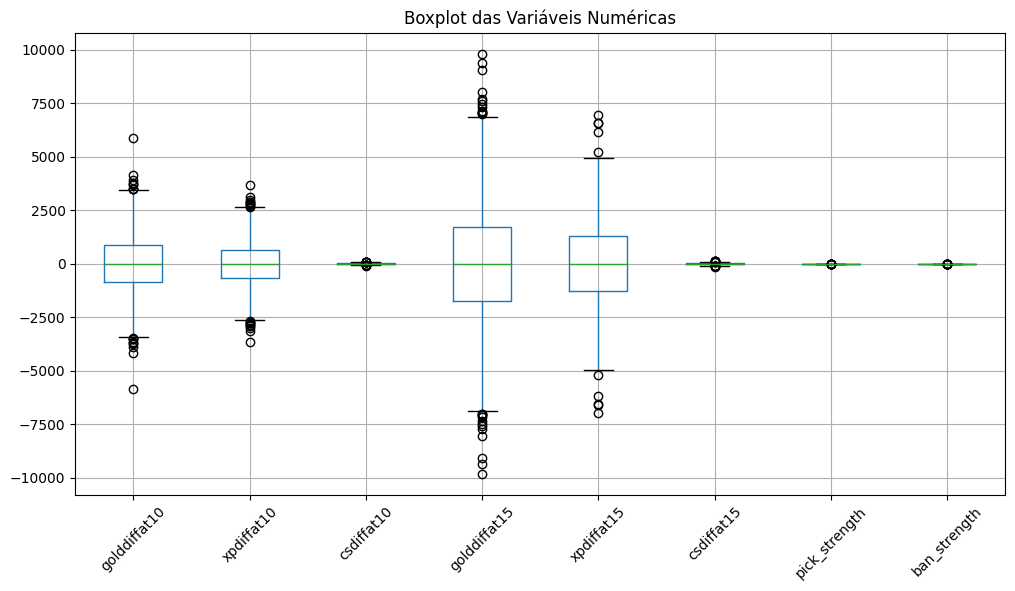

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Criar boxplots para variáveis numéricas
plt.figure(figsize=(12, 6))
df[numeric_features].boxplot()
plt.xticks(rotation=45)
plt.title("Boxplot das Variáveis Numéricas")
plt.show()


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

models = {
    "KNN": Pipeline([
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=25, weights='distance'))
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingClassifier(
            n_estimators=150, learning_rate=0.1,
            max_depth=3, subsample=0.8, random_state=42))
    ]),
    "Regressão Logística": Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(
            C=0.1, penalty='l2', solver='saga',
            max_iter=1000, random_state=42))
    ]),
    "Árvore CART": Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(
            criterion='gini', max_depth=5,
            min_samples_split=20, random_state=42))
    ]),
    "Árvore ID3": Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(
            criterion='entropy', max_depth=5,
            min_samples_split=20, random_state=42))
    ])
}


In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


# 6. TREINAMENTO E AVALIAÇÃO
# ---------------------------------------------------------------
results = {model: {'AUC_Treino': [], 'AUC_Teste': [], 'Acurácia_Teste': [], 'F1-Score_Teste': []} for model in models}

# Validação cruzada no treino
cv = GroupKFold(n_splits=5)
for name, model in models.items():
    auc_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train, groups=groups_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        val_preds = model.predict_proba(X_val)[:,1]
        auc_scores.append(roc_auc_score(y_val, val_preds))

    # Armazenar métricas de treino
    results[name]['AUC_Treino'] = np.mean(auc_scores), np.std(auc_scores)
     # Avaliação final no teste
    model.fit(X_train, y_train)
    test_preds = model.predict_proba(X_test)[:,1]
    results[name]['AUC_Teste'] = roc_auc_score(y_test, test_preds)
    results[name]['Acurácia_Teste'] = accuracy_score(y_test, (test_preds >= 0.5))
    results[name]['F1-Score_Teste'] = f1_score(y_test, (test_preds >= 0.5))



In [ ]:
# Exibir resultados
print("=== Desempenho dos Modelos ===")
for name, metrics in results.items():
    print(f"\nModelo: {name}")
    print(f"AUC (Treino): {metrics['AUC_Treino'][0]:.3f} ± {metrics['AUC_Treino'][1]:.3f}")
    print(f"AUC (Teste): {metrics['AUC_Teste']:.3f}")
    print(f"Acurácia (Teste): {metrics['Acurácia_Teste']:.2%}")
    print(f"F1-Score (Teste): {metrics['F1-Score_Teste']:.3f}")

=== Desempenho dos Modelos ===

Modelo: KNN
AUC (Treino): 0.915 ± 0.010
AUC (Teste): 0.877
Acurácia (Teste): 79.39%
F1-Score (Teste): 0.793

Modelo: Gradient Boosting
AUC (Treino): 0.913 ± 0.015
AUC (Teste): 0.876
Acurácia (Teste): 77.88%
F1-Score (Teste): 0.781

Modelo: Regressão Logística
AUC (Treino): 0.932 ± 0.007
AUC (Teste): 0.889
Acurácia (Teste): 81.21%
F1-Score (Teste): 0.811

Modelo: Árvore CART
AUC (Treino): 0.865 ± 0.011
AUC (Teste): 0.838
Acurácia (Teste): 76.06%
F1-Score (Teste): 0.764

Modelo: Árvore ID3
AUC (Treino): 0.866 ± 0.010
AUC (Teste): 0.805
Acurácia (Teste): 74.55%
F1-Score (Teste): 0.759


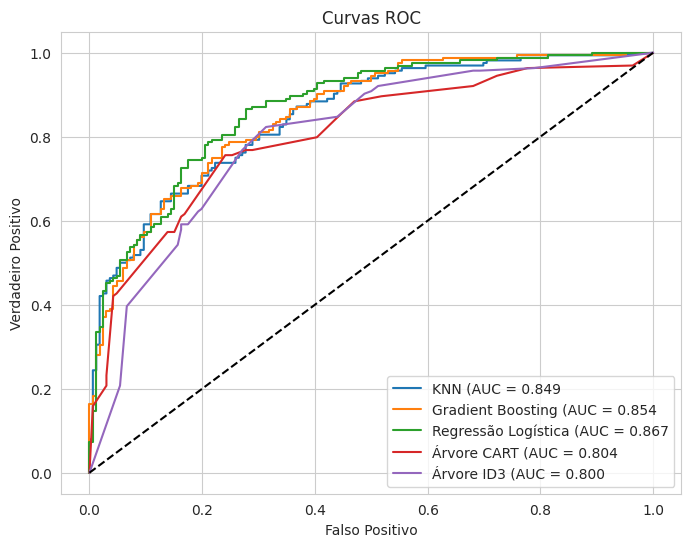

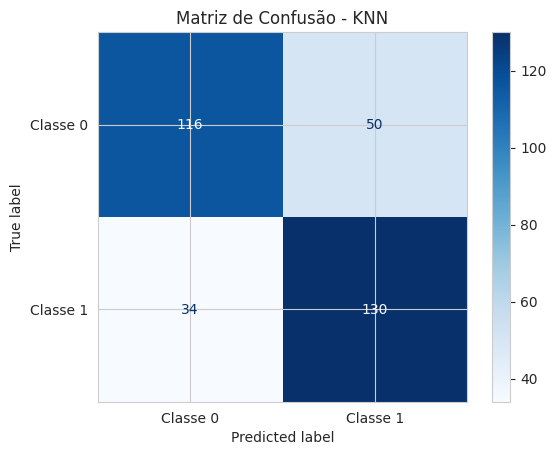

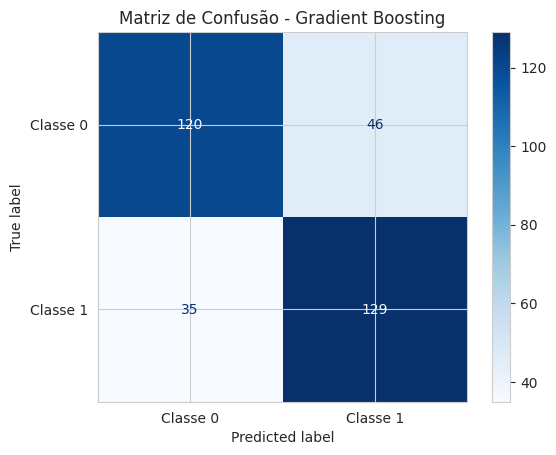

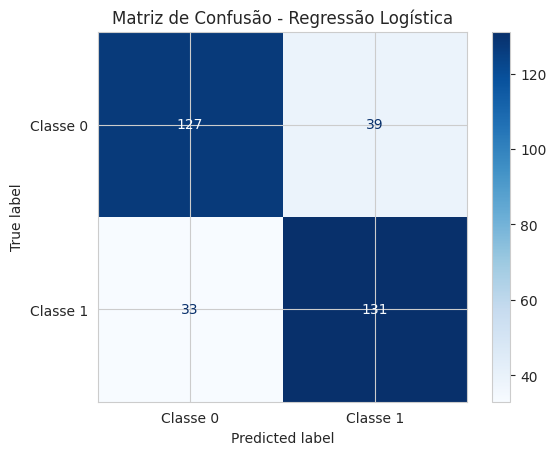

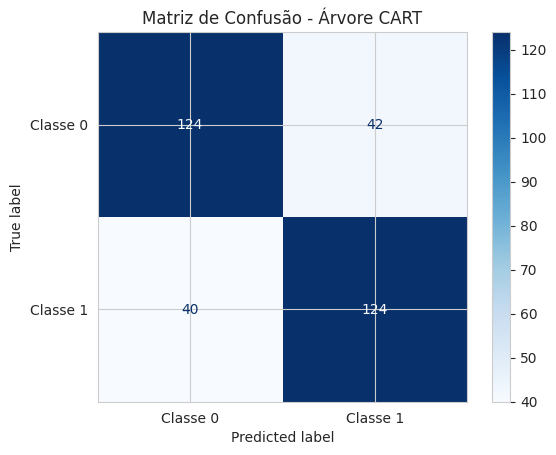

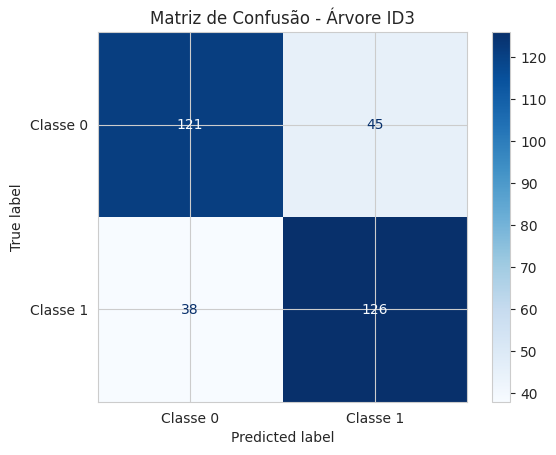

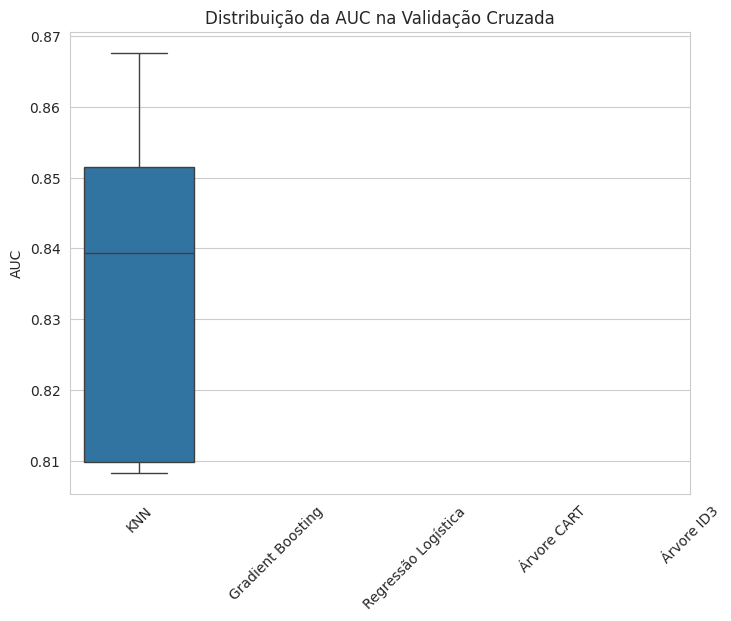

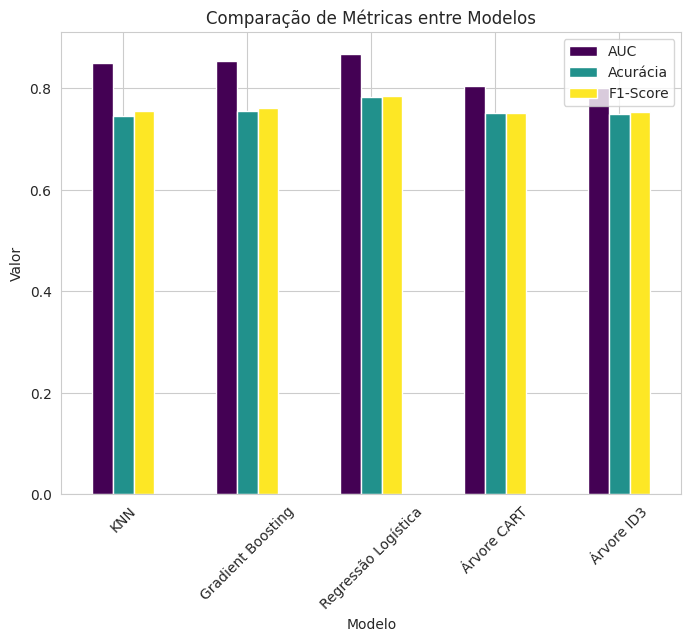

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import shap

# Configuração geral de estilo
sns.set_style("whitegrid")

# Curvas ROC
plt.figure(figsize=(8, 6))
for name, model in models.items():
    test_preds = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, test_preds)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.3f}')

plt.plot([0, 1], [0, 1], 'k--')  # Linha do azar
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curvas ROC')
plt.legend()
plt.show()

# Matrizes de Confusão
for name, model in models.items():
    y_pred = (model.predict_proba(X_test)[:,1] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Classe 0", "Classe 1"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

# Importância das Features (Gradient Boosting e Regressão Logística)
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_).flatten()
    else:
        continue  # Modelos sem feature importance

    feature_names = X_train.columns
    sorted_idx = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(importances)), importances[sorted_idx], tick_label=feature_names[sorted_idx])
    plt.xticks(rotation=90)
    plt.title(f'Importância das Features - {name}')
    plt.show()

# Boxplots das Métricas (AUC na validação cruzada)
plt.figure(figsize=(8, 6))
auc_values = [results[model]['AUC_Treino'][0] for model in models]
sns.boxplot(data=auc_values)
plt.xticks(range(len(models)), models.keys(), rotation=45)
plt.title("Distribuição da AUC na Validação Cruzada")
plt.ylabel("AUC")
plt.show()

# Comparação das métricas entre modelos
metrics_df = {
    "Modelo": list(models.keys()),
    "AUC": [results[model]['AUC_Teste'] for model in models],
    "Acurácia": [results[model]['Acurácia_Teste'] for model in models],
    "F1-Score": [results[model]['F1-Score_Teste'] for model in models]
}
metrics_df = pd.DataFrame(metrics_df)
metrics_df.set_index("Modelo").plot(kind='bar', figsize=(8, 6), colormap='viridis')
plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc
from plotnine import ggplot, aes, geom_line, geom_abline, scale_color_manual, labs, theme
custom_palette = ["#a0714f", "#5c6c4d", "#72898d", "#3f5a66", "#2d3d4b", "#0d1a21"]

# Função para plotar as curvas ROC
def plot_roc_curves_plotnine(models, X_test, y_test):
    # DataFrame para armazenar os dados da curva ROC
    roc_data = pd.DataFrame(columns=['Modelo', 'FPR', 'TPR', 'AUC'])

    for name, model in models.items():
        # Obter as probabilidades previstas para a classe positiva
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Calcular a curva ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Adicionar os dados ao DataFrame
        temp_df = pd.DataFrame({'Modelo': name, 'FPR': fpr, 'TPR': tpr, 'AUC': roc_auc})
        roc_data = pd.concat([roc_data, temp_df], ignore_index=True)

    # Plotar as curvas ROC com plotnine
    plot = (
        ggplot(roc_data, aes(x='FPR', y='TPR', color='Modelo'))
        + geom_line(size=1.2)  # Linhas da curva ROC
        + geom_abline(linetype='dashed', color='gray', size=1)  # Linha de referência (classificador aleatório)
        + scale_color_manual(values=custom_palette)  # Usar a paleta personalizada
        + labs(
            title='Curvas ROC',
            x='Taxa de Falsos Positivos (FPR)',
            y='Taxa de Verdadeiros Positivos (TPR)',
            color='Modelo'
        )
        + theme(
            figure_size=(8, 6),
            axis_text=element_text(size=12),
            axis_title=element_text(size=14),
            legend_title=element_text(size=12),
            legend_text=element_text(size=10)
        )
    )
    print(plot)

# Plotar as curvas ROC para cada modelo
plot_roc_curves_plotnine(models1, X_test, y_test)

<ipython-input-72-18fd33da451d>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


NameError: name 'element_text' is not defined

In [ ]:
import numpy as np
import pandas as pd

from plotnine import (
    ggplot, aes, geom_line, geom_abline, geom_tile, geom_text,
    scale_fill_gradient, scale_fill_manual, scale_color_manual,
    labs, theme_minimal, theme, element_text, geom_bar, coord_flip,
    geom_boxplot, position_dodge
)
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Sua paleta personalizada:
custom_palette = ["#a0714f", "#5c6c4d", "#72898d", "#3f5a66", "#2d3d4b", "#0d1a21"]


In [ ]:
g_roc = (
    ggplot(df_roc, aes(x='fpr', y='tpr', color='Modelo'))
    + geom_line(size=1.2)
    + geom_abline(slope=1, intercept=0, linetype='dashed', color='black')  # Linha do azar
    + scale_color_manual(values=custom_palette)
    + labs(title='Curvas ROC',
           x='Falso Positivo',
           y='Verdadeiro Positivo',
           color='Modelo')
    + theme_minimal()
    + theme(
        legend_title=element_text(size=10),
        legend_text=element_text(size=9),
        figure_size=(10, 8)  # Aumente aqui conforme desejar
    )
)

print(g_roc)


<ggplot: (1000 x 800)>


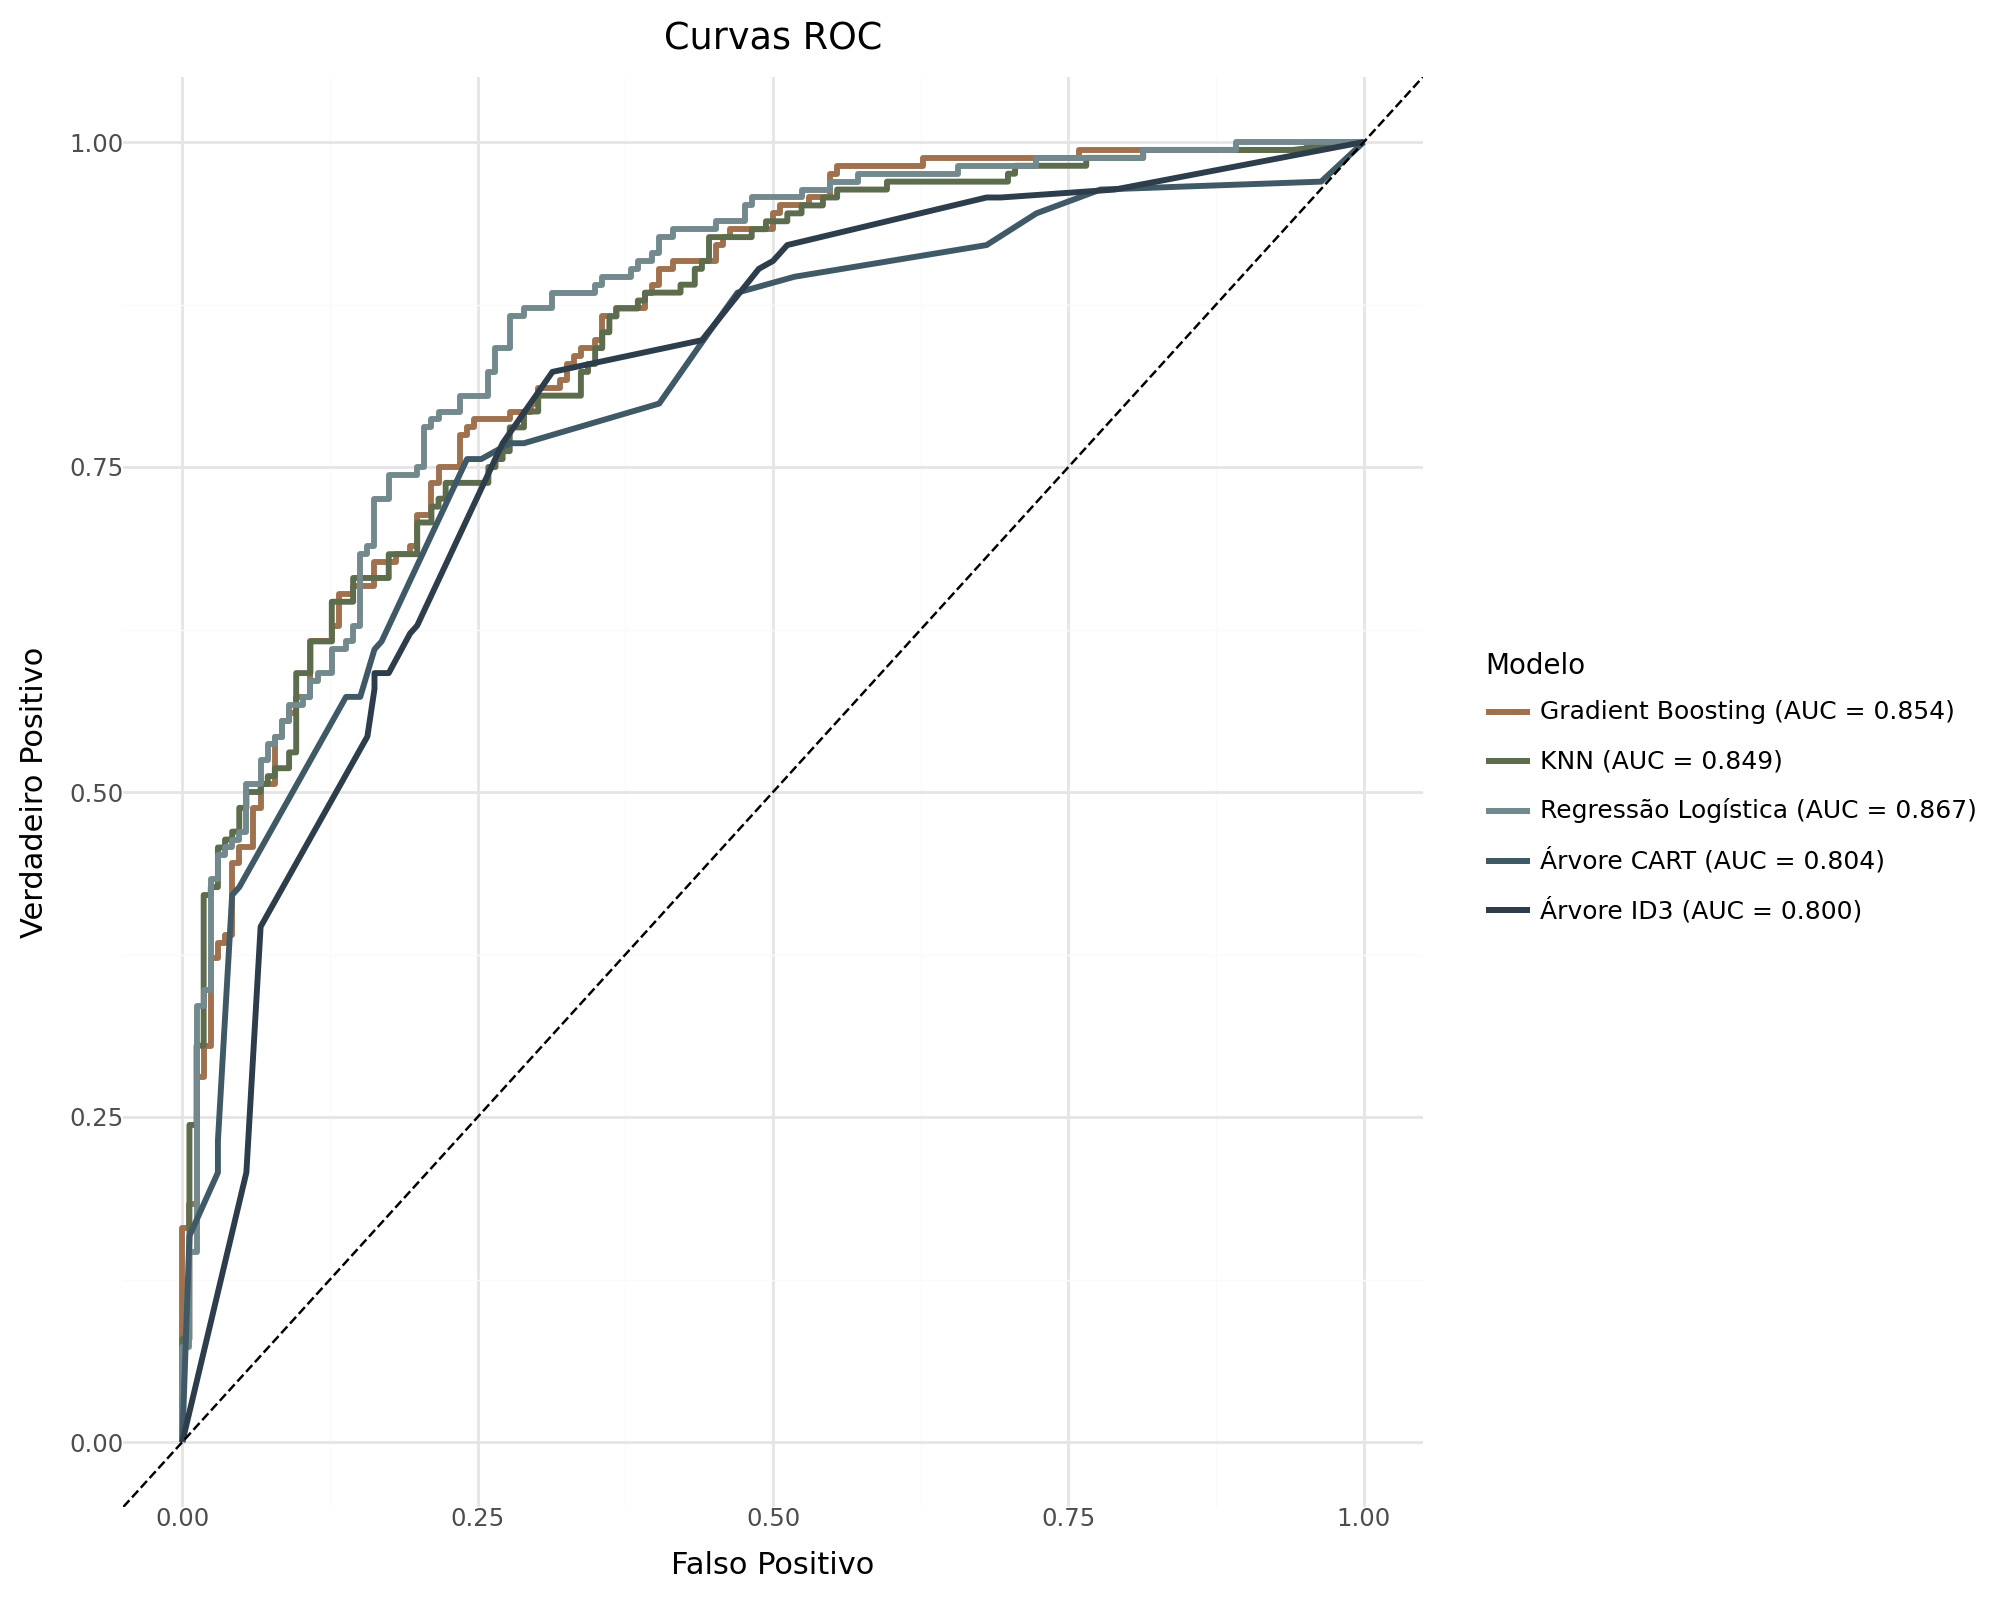

In [ ]:
g_roc

In [ ]:
from sklearn.metrics import confusion_matrix
from plotnine import (
    ggplot, aes, geom_tile, geom_text, scale_fill_gradient,
    facet_wrap, labs, theme_minimal, theme, element_text
)
import pandas as pd

df_all_cm = []

for name, model in models.items():
    # Predição binária (threshold=0.5)
    y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    # DataFrame no formato longo
    cm_df = (
        pd.DataFrame(cm, index=["Classe 0", "Classe 1"], columns=["Classe 0", "Classe 1"])
        .reset_index()
        .melt(id_vars="index")
        .rename(columns={"index": "Real", "variable": "Previsto", "value": "Count"})
    )
    # Adiciona coluna do modelo para facetar depois
    cm_df["Modelo"] = name

    df_all_cm.append(cm_df)

# Concatenar todos os DFs de matriz de confusão
df_all_cm = pd.concat(df_all_cm, ignore_index=True)

# Plot único com facet_wrap para cada modelo
g_cm = (
    ggplot(df_all_cm, aes(x='Previsto', y='Real', fill='Count'))
    + geom_tile()
    + geom_text(aes(label='Count'), color='white', size=12)
    + scale_fill_gradient(low='#3f5a66', high='#0d1a21')  # usando parte da sua paleta
    + labs(title='',
           x='Previsto',
           y='Real')
    + facet_wrap('~Modelo')  # Cada modelo em um "painel"
    + theme_minimal()
    + theme(
        axis_text_x=element_text(size=9),
        axis_text_y=element_text(size=9),
        plot_title=element_text(size=12, weight='bold')
    )
)

print(g_cm)


<ggplot: (640 x 480)>


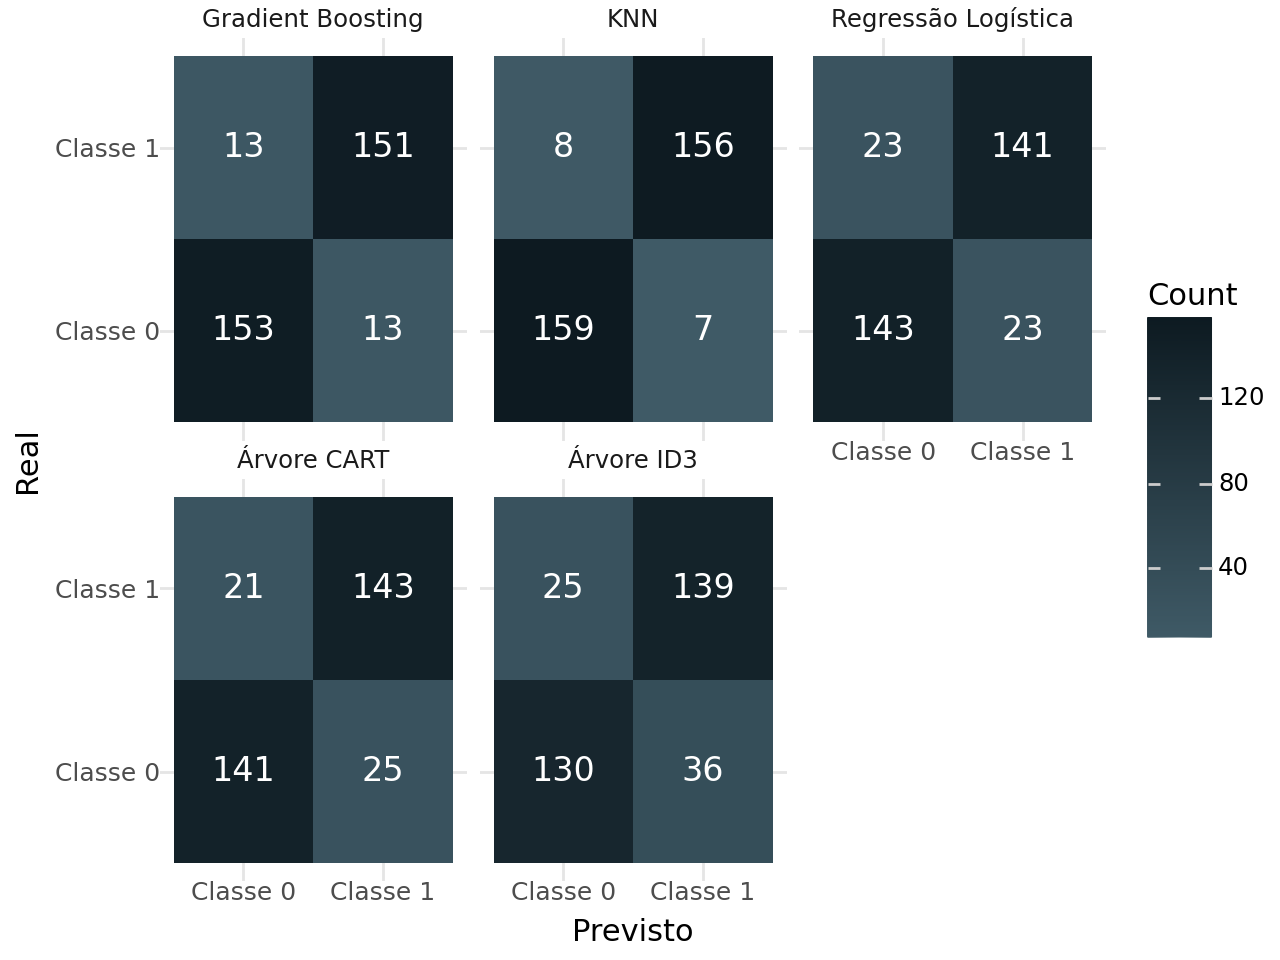

In [ ]:
g_cm

In [ ]:
df_auc_box = pd.DataFrame()

for name in models.keys():
    # Ajuste conforme sua estrutura real do "results"
    # Exemplo: se for results[name]['AUC_Treino'] = [val_fold1, val_fold2, ...]
    auc_values = results[name]['AUC_Treino']  # ou results[name]['AUC_Treino'][0], depende
    temp_df = pd.DataFrame({
        'Modelo': [name]*len(auc_values),
        'AUC': auc_values
    })
    df_auc_box = pd.concat([df_auc_box, temp_df], ignore_index=True)

g_box = (
    ggplot(df_auc_box, aes(x='Modelo', y='AUC', fill='Modelo'))
    + geom_boxplot(position=position_dodge(0.75))
    + scale_fill_manual(values=custom_palette)
    + labs(title="",
           x="Modelo",
           y="AUC",
           fill="Modelo")
    + theme_minimal()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        plot_title=element_text(size=12, weight='bold')
    )
)

print(g_box)


<ggplot: (640 x 480)>


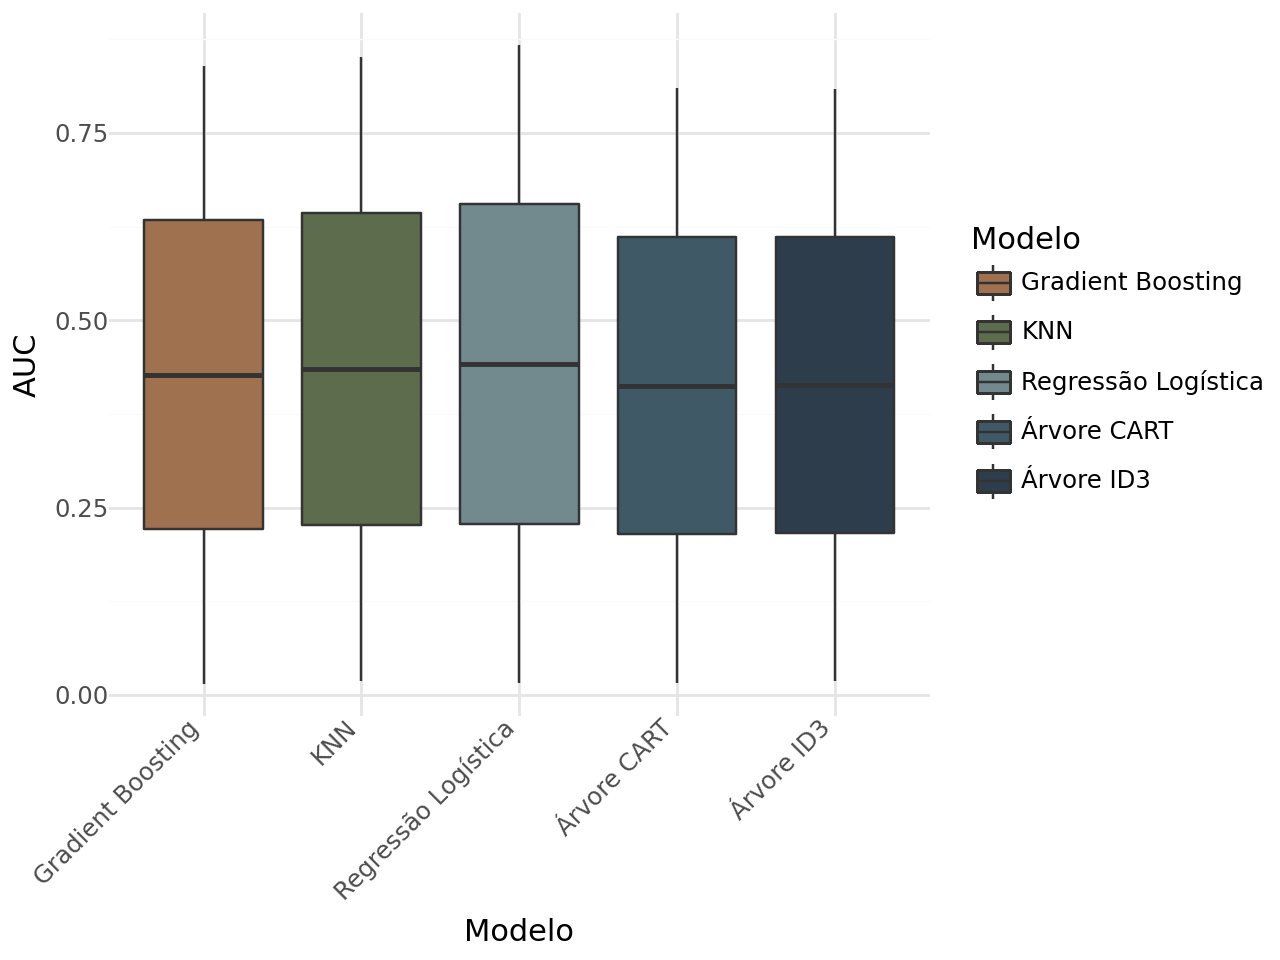

In [ ]:
g_box

In [ ]:
# Criar gráficos de importância de features para Gradient Boosting e Regressão Logística
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_).flatten()
    else:
        continue  # Pula modelos sem importância de features

    # Ordenando as features por importância
    feature_names = np.array(X_train.columns)  # Certifica que é um array
    sorted_idx = np.argsort(importances)[::-1]

    # Criando gráfico
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(importances)), importances[sorted_idx], tick_label=feature_names[sorted_idx])
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importância')
    plt.title(f'Importância das Features - {name}')
    plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

for name, model in models.items():
    try:
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importância': perm_importance.importances_mean
        }).sort_values(by='Importância', ascending=False)

        print(f"\n=== Importância das Features - {name} ===")
        print(feature_importance)

    except Exception as e:
        print(f"Erro ao calcular Permutation Importance para {name}: {e}")



=== Importância das Features - KNN ===
           Feature  Importância
148   ban_strength     0.073636
147  pick_strength     0.064848
108   golddiffat15     0.019394
8            patch     0.015152
109     xpdiffat15     0.015152
..             ...          ...
51          oceans     0.000000
52       chemtechs     0.000000
101     csdiffat10    -0.000303
100     xpdiffat10    -0.003939
10            side    -0.013939

[149 rows x 2 columns]


KeyboardInterrupt: 

In [ ]:
for name, model in models.items():
    try:
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

        feature_importance = pd.DataFrame({
            'Feature': X_train.columns,
            'Importância': perm_importance.importances_mean
        }).sort_values(by='Importância', ascending=False).head(10)  # Mantém apenas as 10 mais importantes

        print(f"\n=== Top 10 Features Mais Importantes - {name} ===")
        print(feature_importance)

    except Exception as e:
        print(f"Erro ao calcular Permutation Importance para {name}: {e}")



=== Top 10 Features Mais Importantes - KNN ===
                   Feature  Importância
148           ban_strength     0.073636
147          pick_strength     0.064848
108           golddiffat15     0.019394
8                    patch     0.015152
109             xpdiffat15     0.015152
110             csdiffat15     0.013636
99            golddiffat10     0.006667
94             minionkills     0.000000
95            monsterkills     0.000000
96   monsterkillsownjungle     0.000000

=== Top 10 Features Mais Importantes - Gradient Boosting ===
           Feature  Importância
148   ban_strength     0.083030
147  pick_strength     0.069697
108   golddiffat15     0.058788
100     xpdiffat10     0.008788
110     csdiffat15     0.008788
10            side     0.006970
101     csdiffat10     0.004242
99    golddiffat10     0.003030
8            patch     0.003030
109     xpdiffat15     0.000606

=== Top 10 Features Mais Importantes - Regressão Logística ===
                   Feature  Import

In [ ]:
model_knn = models["KNN"].named_steps['model']
print("Features:", X_train.columns)  # As features são as mesmas usadas no modelo.

Features: Index(['datacompleteness', 'url', 'league', 'year', 'split', 'playoffs',
       'date', 'game', 'patch', 'participantid',
       ...
       'xpdiffat25', 'csdiffat25', 'killsat25', 'assistsat25', 'deathsat25',
       'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25', 'pick_strength',
       'ban_strength'],
      dtype='object', length=149)


In [ ]:
import pandas as pd

# Ajustar para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Agora, quando você imprimir, todas as features serão exibidas
print("Features:", X_train.columns)
# Ajustar a largura das colunas
pd.set_option('display.max_colwidth', None)

# Exibir todas as colunas novamente
print("Features:", X_train.columns)
# Voltar ao comportamento padrão de exibição
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')


Features: Index(['datacompleteness', 'url', 'league', 'year', 'split', 'playoffs',
       'date', 'game', 'patch', 'participantid',
       ...
       'xpdiffat25', 'csdiffat25', 'killsat25', 'assistsat25', 'deathsat25',
       'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25', 'pick_strength',
       'ban_strength'],
      dtype='object', length=149)
Features: Index(['datacompleteness', 'url', 'league', 'year', 'split', 'playoffs',
       'date', 'game', 'patch', 'participantid',
       ...
       'xpdiffat25', 'csdiffat25', 'killsat25', 'assistsat25', 'deathsat25',
       'opp_killsat25', 'opp_assistsat25', 'opp_deathsat25', 'pick_strength',
       'ban_strength'],
      dtype='object', length=149)


In [ ]:
# Dividir as colunas em partes e imprimir
chunks = [X_train.columns[i:i + 50] for i in range(0, len(X_train.columns), 50)]
for chunk in chunks:
    print(chunk)


Index(['datacompleteness', 'url', 'league', 'year', 'split', 'playoffs',
       'date', 'game', 'patch', 'participantid', 'side', 'position',
       'playername', 'playerid', 'teamname', 'teamid', 'champion', 'ban1',
       'ban2', 'ban3', 'ban4', 'ban5', 'pick1', 'pick2', 'pick3', 'pick4',
       'pick5', 'gamelength', 'kills', 'deaths', 'assists', 'teamkills',
       'teamdeaths', 'doublekills', 'triplekills', 'quadrakills', 'pentakills',
       'firstblood', 'firstbloodkill', 'firstbloodassist', 'firstbloodvictim',
       'team kpm', 'ckpm', 'firstdragon', 'dragons', 'opp_dragons',
       'elementaldrakes', 'opp_elementaldrakes', 'infernals', 'mountains'],
      dtype='object')
Index(['clouds', 'oceans', 'chemtechs', 'hextechs', 'dragons (type unknown)',
       'elders', 'opp_elders', 'firstherald', 'heralds', 'opp_heralds',
       'void_grubs', 'opp_void_grubs', 'firstbaron', 'barons', 'opp_barons',
       'firsttower', 'towers', 'opp_towers', 'firstmidtower',
       'firsttothreet

In [ ]:
# Acessar as features após o pré-processamento
preprocessor = models["KNN"].named_steps['preprocessor']
X_train_transformed = preprocessor.transform(X_train)

# Verificar o número de features antes e depois
print(f"Antes do pré-processamento: {X_train.shape[1]} features")
print(f"Após o pré-processamento: {X_train_transformed.shape[1]} features")


Antes do pré-processamento: 149 features
Após o pré-processamento: 11 features


In [ ]:
print(preprocessor)


ColumnTransformer(transformers=[('scaler', RobustScaler(),
                                 ['golddiffat10', 'xpdiffat10', 'csdiffat10',
                                  'golddiffat15', 'xpdiffat15', 'csdiffat15',
                                  'pick_strength', 'ban_strength']),
                                ('onehot', OneHotEncoder(drop='first'),
                                 ['side', 'patch'])])


In [ ]:
print("Categorias de 'side':", X_train['side'].unique())
print("Categorias de 'patch':", X_train['patch'].unique())

Categorias de 'side': [1 0]
Categorias de 'patch': [15.01 15.02 15.03]


In [ ]:
model = models["Gradient Boosting"].named_steps['model']
importances = model.feature_importances_

# Exibir as importâncias com os nomes das features
feature_names = ['golddiffat10', 'xpdiffat10', 'csdiffat10', 'golddiffat15', 'xpdiffat15', 'csdiffat15', 'pick_strength', 'ban_strength', 'side', 'patch']
for name, importance in zip(feature_names, importances):
    print(f"Feature: {name}, Importance: {importance}")


Feature: golddiffat10, Importance: 0.023958037449058802
Feature: xpdiffat10, Importance: 0.03678683528556972
Feature: csdiffat10, Importance: 0.01845985432399164
Feature: golddiffat15, Importance: 0.3592703103526435
Feature: xpdiffat15, Importance: 0.04274926476593483
Feature: csdiffat15, Importance: 0.05233423920860441
Feature: pick_strength, Importance: 0.21250990762326302
Feature: ban_strength, Importance: 0.2469522728974369
Feature: side, Importance: 0.004045563272504025
Feature: patch, Importance: 0.001685464918864585


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Criando novo ColumnTransformer sem as features 'side' e 'patch'
new_preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), [
            'golddiffat10', 'xpdiffat10', 'csdiffat10',
            'golddiffat15', 'xpdiffat15', 'csdiffat15',
            'pick_strength', 'ban_strength'
        ])
    ]
)

# Criando o novo pipeline
new_model = Pipeline([
    ('preprocessor', new_preprocessor),
    ('model', GradientBoostingClassifier(
        n_estimators=150, learning_rate=0.1,
        max_depth=3, subsample=0.8, random_state=42))
])

# Dividindo os dados (substitua X e y pelos seus dados)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo sem 'side' e 'patch'
new_model.fit(X_train, y_train)

# Fazendo previsões
y_pred = new_model.predict(X_test)

# Avaliando o desempenho
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo sem side e patch: {accuracy:.4f}')


Acurácia do modelo sem side e patch: 0.8333


In [ ]:
df.loc[:, new_preprocessor + ['result']].head(10)


TypeError: unsupported operand type(s) for +: 'ColumnTransformer' and 'list'

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

models1 = {
    "KNN": Pipeline([
        ('preprocessor', new_preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=25, weights='distance'))
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', new_preprocessor),
        ('model', GradientBoostingClassifier(
            n_estimators=150, learning_rate=0.1,
            max_depth=3, subsample=0.8, random_state=42))
    ]),
    "Regressão Logística": Pipeline([
        ('preprocessor', new_preprocessor),
        ('model', LogisticRegression(
            C=0.1, penalty='l2', solver='saga',
            max_iter=1000, random_state=42))
    ]),
    "Árvore CART": Pipeline([
        ('preprocessor', new_preprocessor),
        ('model', DecisionTreeClassifier(
            criterion='gini', max_depth=5,
            min_samples_split=20, random_state=42))
    ]),
    "Árvore ID3": Pipeline([
        ('preprocessor', new_preprocessor),
        ('model', DecisionTreeClassifier(
            criterion='entropy', max_depth=5,
            min_samples_split=20, random_state=42))
    ])
}


In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


# 6. TREINAMENTO E AVALIAÇÃO
# ---------------------------------------------------------------
results = {model: {'AUC_Treino': [], 'AUC_Teste': [], 'Acurácia_Teste': [], 'F1-Score_Teste': []} for model in models1}

# Validação cruzada no treino
cv = GroupKFold(n_splits=5)
for name, model in models1.items():
    auc_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train, groups=groups_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        val_preds = model.predict_proba(X_val)[:,1]
        auc_scores.append(roc_auc_score(y_val, val_preds))

    # Armazenar métricas de treino
    results[name]['AUC_Treino'] = np.mean(auc_scores), np.std(auc_scores)
     # Avaliação final no teste
    model.fit(X_train, y_train)
    test_preds = model.predict_proba(X_test)[:,1]
    results[name]['AUC_Teste'] = roc_auc_score(y_test, test_preds)
    results[name]['Acurácia_Teste'] = accuracy_score(y_test, (test_preds >= 0.5))
    results[name]['F1-Score_Teste'] = f1_score(y_test, (test_preds >= 0.5))


In [ ]:
# Exibir resultados
print("=== Desempenho dos Modelos ===")
for name, metrics in results.items():
    print(f"\nModelo: {name}")
    print(f"AUC (Treino): {metrics['AUC_Treino'][0]:.3f} ± {metrics['AUC_Treino'][1]:.3f}")
    print(f"AUC (Teste): {metrics['AUC_Teste']:.3f}")
    print(f"Acurácia (Teste): {metrics['Acurácia_Teste']:.2%}")
    print(f"F1-Score (Teste): {metrics['F1-Score_Teste']:.3f}")

=== Desempenho dos Modelos ===

Modelo: KNN
AUC (Treino): 0.913 ± 0.011
AUC (Teste): 0.925
Acurácia (Teste): 85.15%
F1-Score (Teste): 0.856

Modelo: Gradient Boosting
AUC (Treino): 0.899 ± 0.008
AUC (Teste): 0.917
Acurácia (Teste): 83.33%
F1-Score (Teste): 0.837

Modelo: Regressão Logística
AUC (Treino): 0.924 ± 0.011
AUC (Teste): 0.930
Acurácia (Teste): 85.45%
F1-Score (Teste): 0.855

Modelo: Árvore CART
AUC (Treino): 0.861 ± 0.035
AUC (Teste): 0.886
Acurácia (Teste): 80.00%
F1-Score (Teste): 0.809

Modelo: Árvore ID3
AUC (Treino): 0.865 ± 0.015
AUC (Teste): 0.888
Acurácia (Teste): 80.30%
F1-Score (Teste): 0.808


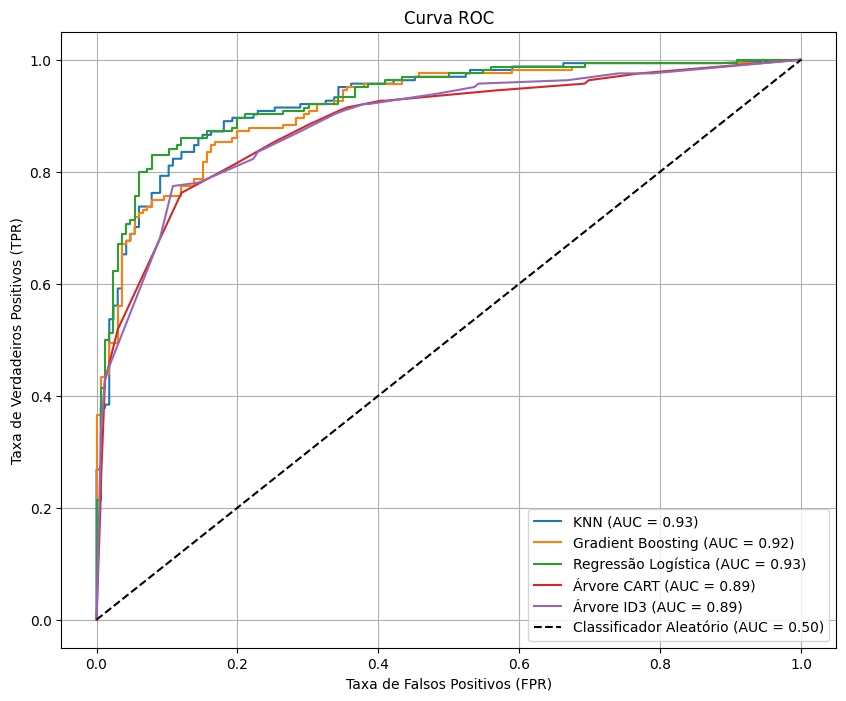

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Função para plotar a curva ROC
def plot_roc_curve(models1, X_test, y_test):
    plt.figure(figsize=(10, 8))

    for name, model in models1.items():
        # Obter as probabilidades previstas para a classe positiva
        y_pred_prob = model.predict_proba(X_test)[:, 1]

        # Calcular a curva ROC
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Plotar a curva ROC
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Plotar a linha de referência (classificador aleatório)
    plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório (AUC = 0.50)')

    # Configurações do gráfico
    plt.xlabel('Taxa de Falsos Positivos (FPR)')
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plotar a curva ROC para os modelos
plot_roc_curve(models1, X_test, y_test)

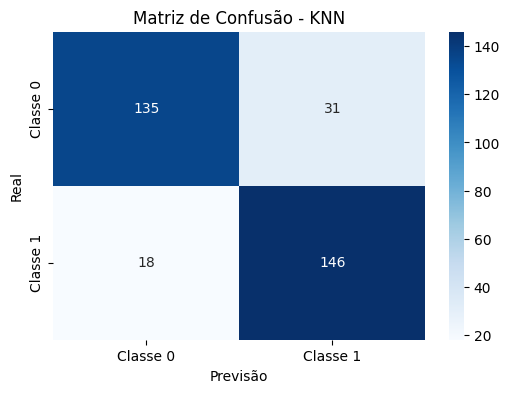

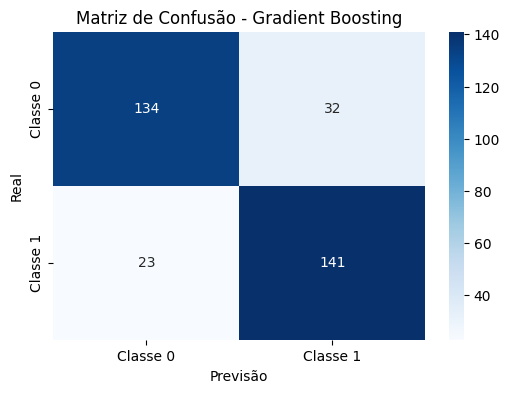

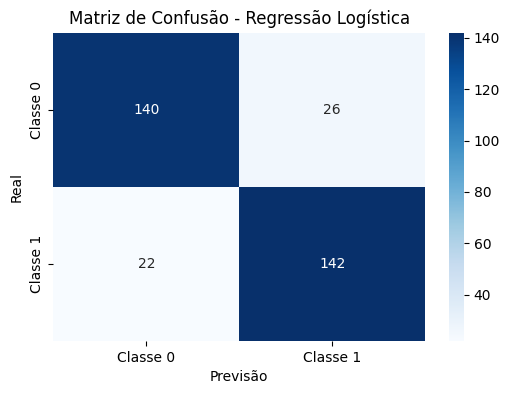

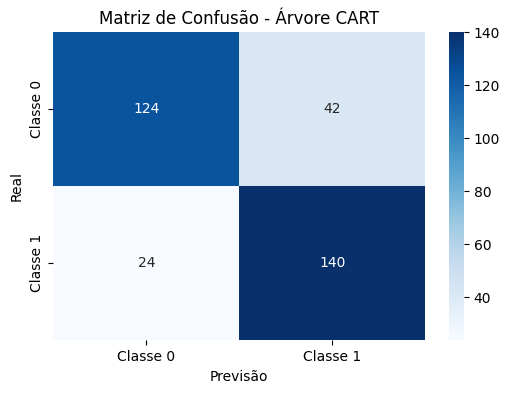

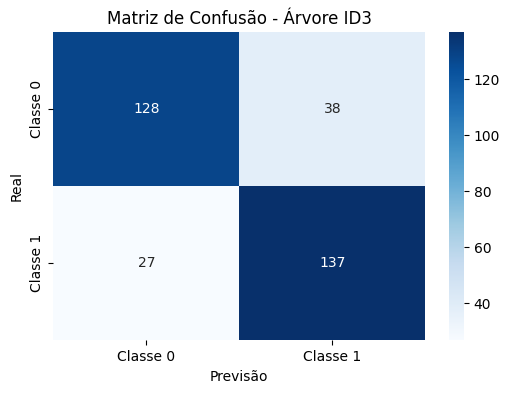

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Função para plotar a matriz de confusão
def plot_confusion_matrix(models1, X_test, y_test):
    for name, model in models1.items():
        # Fazer previsões no conjunto de teste
        y_pred = model.predict(X_test)

        # Calcular a matriz de confusão
        cm = confusion_matrix(y_test, y_pred)

        # Plotar a matriz de confusão usando Seaborn
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Classe 0', 'Classe 1'],
                    yticklabels=['Classe 0', 'Classe 1'])
        plt.title(f'Matriz de Confusão - {name}')
        plt.xlabel('Previsão')
        plt.ylabel('Real')
        plt.show()

# Plotar a matriz de confusão para cada modelo
plot_confusion_matrix(models1, X_test, y_test)

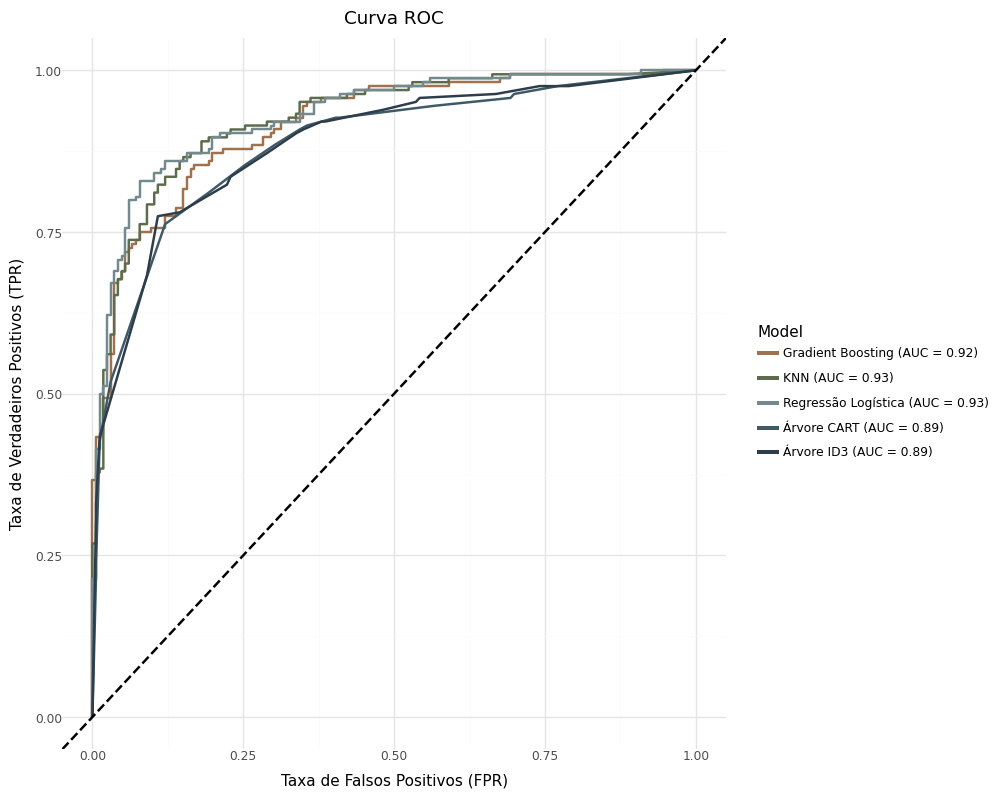

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_line, geom_abline, theme_minimal, labs, scale_color_manual
from sklearn.metrics import roc_curve, auc

# Paleta de cores personalizada
custom_palette = ["#a0714f", "#5c6c4d", "#72898d", "#3f5a66", "#2d3d4b", "#0d1a21"]

# Função para plotar a curva ROC usando plotnine
def plot_roc_curve(models1, X_test, y_test):
    roc_data = []

    for i, (name, model) in enumerate(models1.items()):
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Criar DataFrame para o modelo atual
        df = pd.DataFrame({
            'FPR': fpr,
            'TPR': tpr,
            'Model': f"{name} (AUC = {roc_auc:.2f})",
        })
        roc_data.append(df)

    # Concatenar todos os DataFrames
    roc_df = pd.concat(roc_data, ignore_index=True)

    # Criar gráfico com plotnine
    p = (ggplot(roc_df, aes(x='FPR', y='TPR', color='Model'))
         + geom_line(size=1)
         + geom_abline(slope=1, intercept=0, linetype="dashed", color="black", size=1)  # Linha de referência
         + scale_color_manual(values=custom_palette[:len(models1)])  # Aplicar paleta personalizada
         + theme_minimal()
         + labs(title="Curva ROC", x="Taxa de Falsos Positivos (FPR)", y="Taxa de Verdadeiros Positivos (TPR)")
    )

    # Ajustar o tamanho da figura
    fig = p.draw()
    fig.set_size_inches(10, 8)  # Aumentando o tamanho da figura
    return fig

# Plotar a curva ROC para os modelos
plot_roc_curve(models1, X_test, y_test)


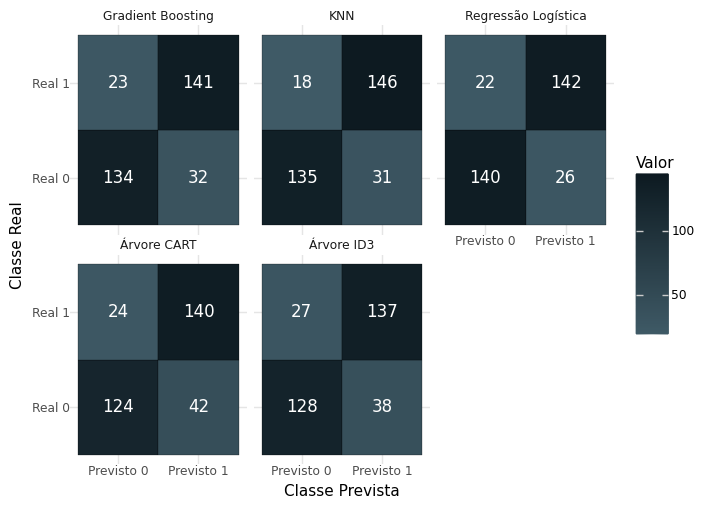

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_tile, geom_text, scale_fill_gradient, theme_minimal, labs, facet_wrap
from sklearn.metrics import confusion_matrix

# Função para calcular e exibir as matrizes de confusão com plotnine
def plot_confusion_matrices(models1, X_test, y_test):
    conf_data = []

    for name, model in models1.items():
        # Obter as previsões do modelo
        y_pred = model.predict(X_test)

        # Calcular a matriz de confusão
        cm = confusion_matrix(y_test, y_pred)

        # Transformar em DataFrame para visualização
        df_cm = pd.DataFrame(cm, columns=["Previsto 0", "Previsto 1"], index=["Real 0", "Real 1"])
        df_cm = df_cm.reset_index().melt(id_vars="index", var_name="Previsto", value_name="Valor")
        df_cm["Modelo"] = name
        conf_data.append(df_cm)

    # Concatenar todas as matrizes de confusão
    conf_df = pd.concat(conf_data, ignore_index=True)

    # Criar gráfico com plotnine
    p = (ggplot(conf_df, aes(x="Previsto", y="index", fill="Valor"))
         + geom_tile(color="black")
         + geom_text(aes(label="Valor"), size=12, color="white")
         + scale_fill_gradient(low="#3f5a66", high="#0d1a21")
         + theme_minimal()
         + labs(title="", x="Classe Prevista", y="Classe Real")
         + facet_wrap("~Modelo")  # Criar um gráfico separado para cada modelo
    )

    # Ajustar o tamanho da figura
    fig = p.draw()
    fig.set_size_inches(7, 5)
    return fig

# Gerar e exibir as matrizes de confusão
plot_confusion_matrices(models1, X_test, y_test)


In [ ]:
from plotnine import ggplot, aes, geom_boxplot, scale_fill_manual, labs, theme_minimal, theme, element_text
import pandas as pd

# Inicializa o DataFrame para armazenar os valores de AUC
df_auc_box = pd.DataFrame()

# Itera sobre os modelos e coleta os valores de AUC
for name in models1.keys():
    # Exemplo: acessando os resultados de AUC para o treinamento (ajuste conforme sua estrutura)
    auc_values = results[name]['AUC_Treino']  # Ajuste aqui conforme a estrutura do seu dicionário de resultados

    # Criação de um DataFrame temporário com os valores de AUC
    temp_df = pd.DataFrame({
        'Modelo': [name] * len(auc_values),
        'AUC': auc_values
    })

    # Concatena o DataFrame temporário ao DataFrame final
    df_auc_box = pd.concat([df_auc_box, temp_df], ignore_index=True)

# Criação do gráfico boxplot usando Plotnine
g_box = (
    ggplot(df_auc_box, aes(x='Modelo', y='AUC', fill='Modelo'))
    + geom_boxplot(position='dodge')  # Boxplot com ajuste de posição
    + scale_fill_manual(values=["#a0714f", "#5c6c4d", "#72898d", "#3f5a66", "#2d3d4b", "#0d1a21"])  # Adapte sua paleta personalizada aqui
    + labs(title="",
           x="Modelo",
           y="AUC",
           fill="Modelo")
    + theme_minimal()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),  # Rotaciona os labels do eixo X
        plot_title=element_text(size=14, weight='bold'),  # Título do gráfico
        figure_size=(6, 5)  # Ajusta o tamanho da figura
    )
)
# Exibir o gráfico
print(g_box)


<ggplot: (600 x 500)>


In [ ]:
# Verificar as chaves disponíveis em `results`
print(results.keys())  # Verificar os modelos disponíveis

# Exemplo corrigido para acessar as métricas de um modelo específico
print(results['KNN'].keys())  # Verificar as métricas disponíveis para o modelo KNN


dict_keys(['KNN', 'Gradient Boosting', 'Regressão Logística', 'Árvore CART', 'Árvore ID3'])
dict_keys(['AUC_Treino', 'AUC_Teste', 'Acurácia_Teste', 'F1-Score_Teste'])


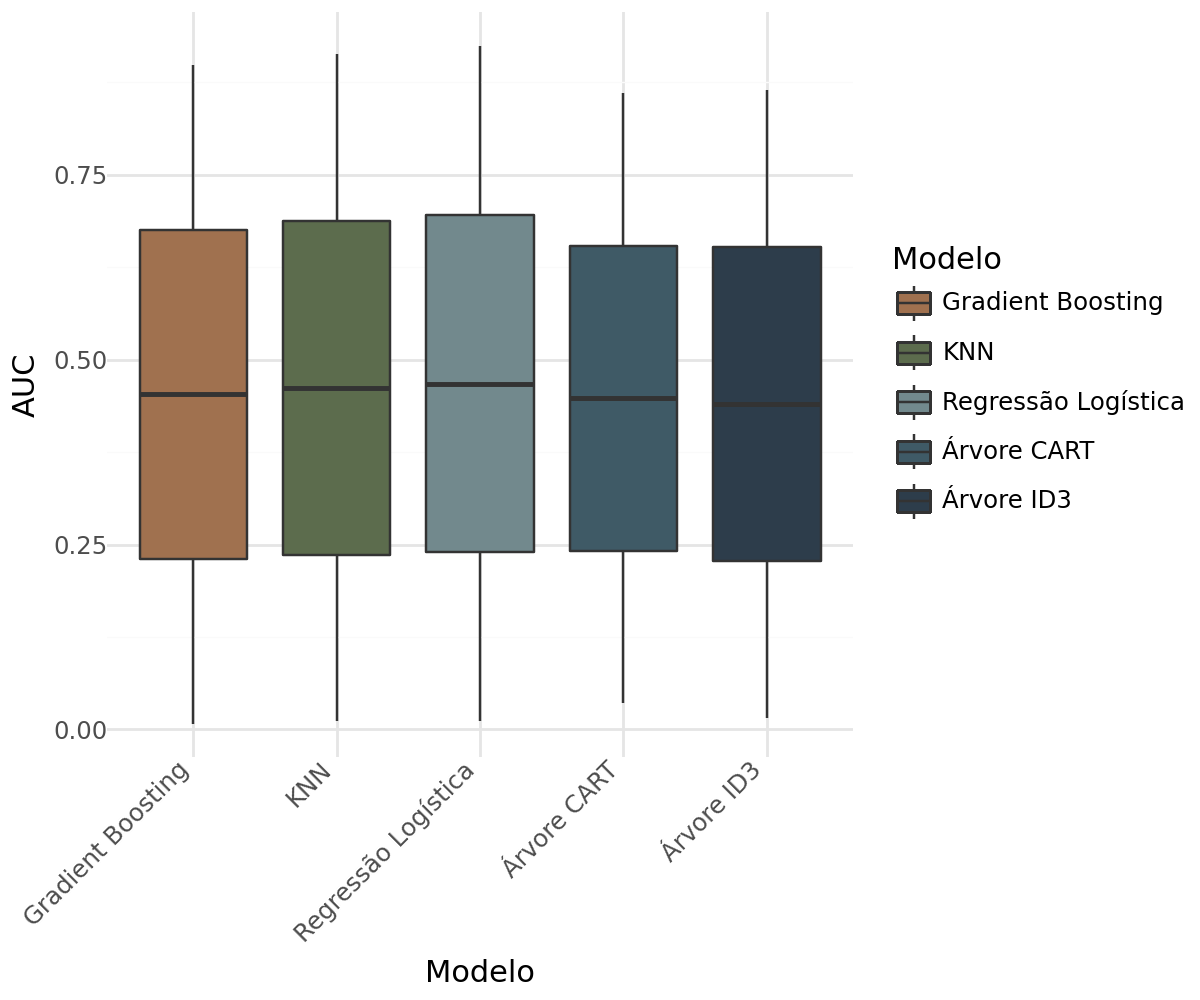

In [ ]:
g_box

In [ ]:
!pip install gridextra


ERROR: Could not find a version that satisfies the requirement gridextra (from versions: none)
ERROR: No matching distribution found for gridextra


In [ ]:
import pandas as pd
from plotnine import ggplot, aes, geom_boxplot, scale_fill_manual, labs, theme_minimal, theme, element_text

# Primeiro, reorganizar os dados para que as métricas estejam em uma única coluna
metrics_df_long = pd.melt(metrics_df, id_vars=['Modelo'], value_vars=['AUC', 'Acurácia', 'F1-Score'],
                         var_name='Métrica', value_name='Valor')

# Criar uma paleta de cores com 5 cores diferentes para cada modelo
custom_palette = ["#a0714f", "#5c6c4d", "#72898d", "#3f5a66", "#2d3d4b", "#0d1a21"]

# Criar o gráfico combinando todas as métricas em um único boxplot
g_combined = (
    ggplot(metrics_df_long, aes(x='Modelo', y='Valor', fill='Modelo'))
    + geom_boxplot()
    + scale_fill_manual(values=custom_palette)
    + facet_wrap('~Métrica', scales='free_y')  # Usando facetas para dividir as métricas
    + labs(title="", x="Modelo", y="Valor")
    + theme_minimal()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        plot_title=element_text(size=12, weight='bold'),
        figure_size=(8, 4)  # Ajusta o tamanho da figura
    )
)

# Exibir o gráfico
print(g_combined)


<ggplot: (800 x 400)>


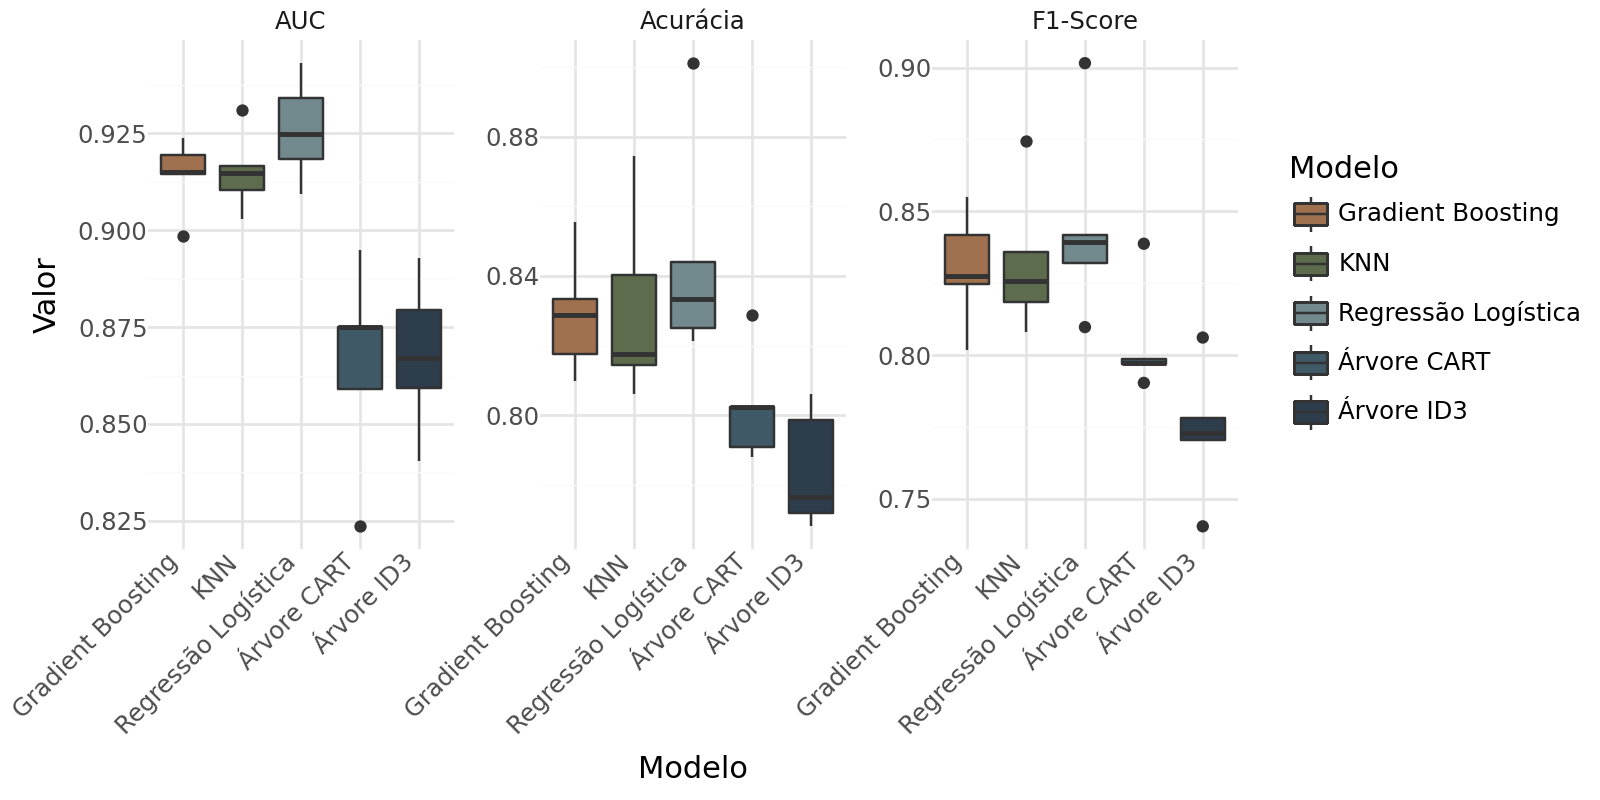

In [ ]:
g_combined

In [ ]:
model = models1["Gradient Boosting"].named_steps['model']
importances = model.feature_importances_

# Exibir as importâncias com os nomes das features
feature_names = ['golddiffat10', 'xpdiffat10', 'csdiffat10',
            'golddiffat15', 'xpdiffat15', 'csdiffat15',
            'pick_strength', 'ban_strength']
for name, importance in zip(feature_names, importances):
    print(f"Feature: {name}, Importance: {importance}")

Feature: golddiffat10, Importance: 0.027640767964638137
Feature: xpdiffat10, Importance: 0.04406900097739179
Feature: csdiffat10, Importance: 0.03520926660034955
Feature: golddiffat15, Importance: 0.3036730229117056
Feature: xpdiffat15, Importance: 0.07618424502517171
Feature: csdiffat15, Importance: 0.04349132390804897
Feature: pick_strength, Importance: 0.23200590838255053
Feature: ban_strength, Importance: 0.23772646423014365


In [ ]:
# Supondo que o modelo de Regressão Logística esteja no pipeline "models1" (como no Gradient Boosting)
model_logistic = models1["Regressão Logística"].named_steps['model']  # Acessa o modelo de Regressão Logística

# Coletando os coeficientes
importances_logistic = model_logistic.coef_[0]

# Definindo os nomes das features
feature_names = ['golddiffat10', 'xpdiffat10', 'csdiffat10',
                 'golddiffat15', 'xpdiffat15', 'csdiffat15',
                 'pick_strength', 'ban_strength']

# Exibindo as importâncias das features (coeficientes)
for name, importance in zip(feature_names, importances_logistic):
    print(f"Feature: {name}, Importance: {importance}")


Feature: golddiffat10, Importance: -0.1484925210482581
Feature: xpdiffat10, Importance: 0.32952358894239153
Feature: csdiffat10, Importance: 0.18358671669076404
Feature: golddiffat15, Importance: 1.1363279245189881
Feature: xpdiffat15, Importance: 0.3308341279894378
Feature: csdiffat15, Importance: 0.3283444794712617
Feature: pick_strength, Importance: 1.2913637392586752
Feature: ban_strength, Importance: 1.4383290908165092


In [ ]:
# Acessando o modelo de Árvore de Decisão (CART) no pipeline
model_cart = models1["Árvore CART"].named_steps['model']

# Coletando as importâncias das features
importances_cart = model_cart.feature_importances_

# Exibindo as importâncias das features (para Árvore CART)
for name, importance in zip(feature_names, importances_cart):
    print(f"Feature: {name}, Importance: {importance}")


Feature: golddiffat10, Importance: 0.0
Feature: xpdiffat10, Importance: 0.0
Feature: csdiffat10, Importance: 0.02360233681708186
Feature: golddiffat15, Importance: 0.44245047942491245
Feature: xpdiffat15, Importance: 0.04690643417311482
Feature: csdiffat15, Importance: 0.05336346515137543
Feature: pick_strength, Importance: 0.24824115700587826
Feature: ban_strength, Importance: 0.18543612742763732


In [ ]:
# Acessando o modelo de Árvore de Decisão (ID3) no pipeline
model_id3 = models1["Árvore ID3"].named_steps['model']

# Coletando as importâncias das features
importances_id3 = model_id3.feature_importances_

# Exibindo as importâncias das features (para Árvore ID3)
for name, importance in zip(feature_names, importances_id3):
    print(f"Feature: {name}, Importance: {importance}")


Feature: golddiffat10, Importance: 0.008433204556979424
Feature: xpdiffat10, Importance: 0.0
Feature: csdiffat10, Importance: 0.008160157661044621
Feature: golddiffat15, Importance: 0.4217414403205331
Feature: xpdiffat15, Importance: 0.048866304518270315
Feature: csdiffat15, Importance: 0.043094976948067
Feature: pick_strength, Importance: 0.21833537632346345
Feature: ban_strength, Importance: 0.25136853967164197


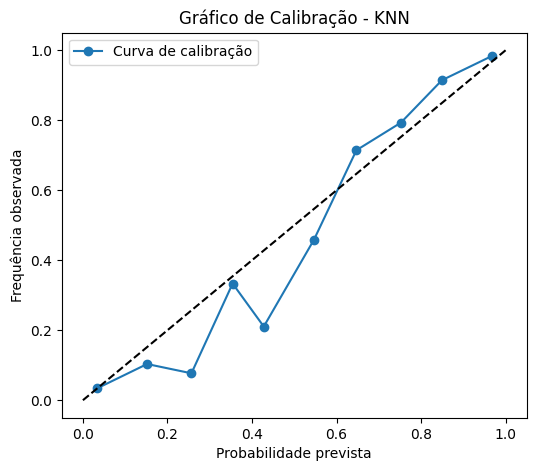

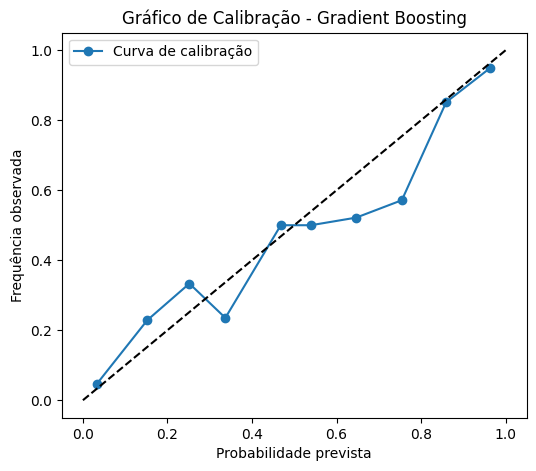

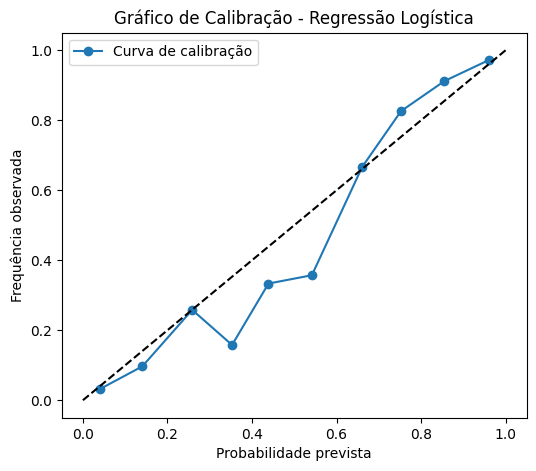

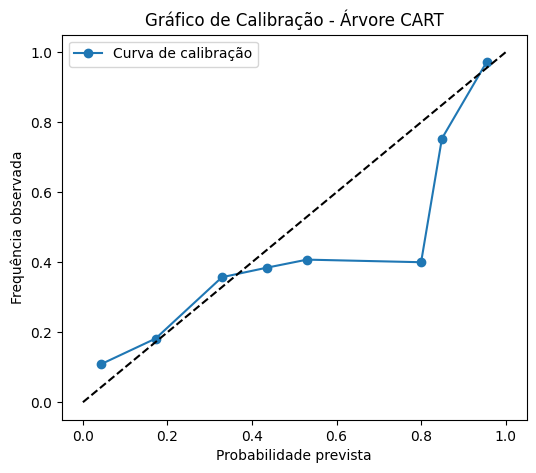

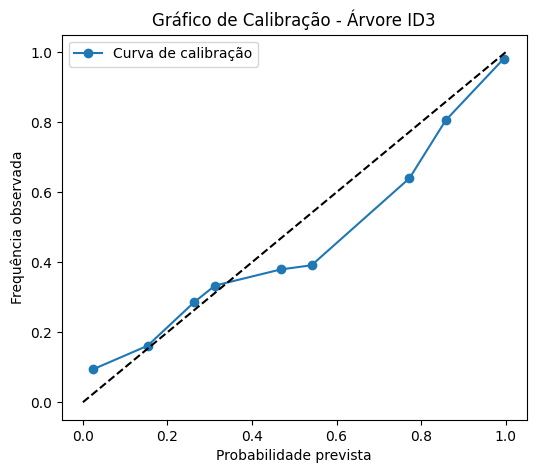

In [ ]:
from sklearn.calibration import calibration_curve

# Gráficos de Calibração Individuais
for name, model in models1.items():
    plt.figure(figsize=(6, 5))
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

    plt.plot(prob_pred, prob_true, marker='o', label="Curva de calibração")
    plt.plot([0, 1], [0, 1], 'k--')  # Linha ideal de calibração

    plt.xlabel("Probabilidade prevista")
    plt.ylabel("Frequência observada")
    plt.title(f"Gráfico de Calibração - {name}")
    plt.legend()
    plt.show()

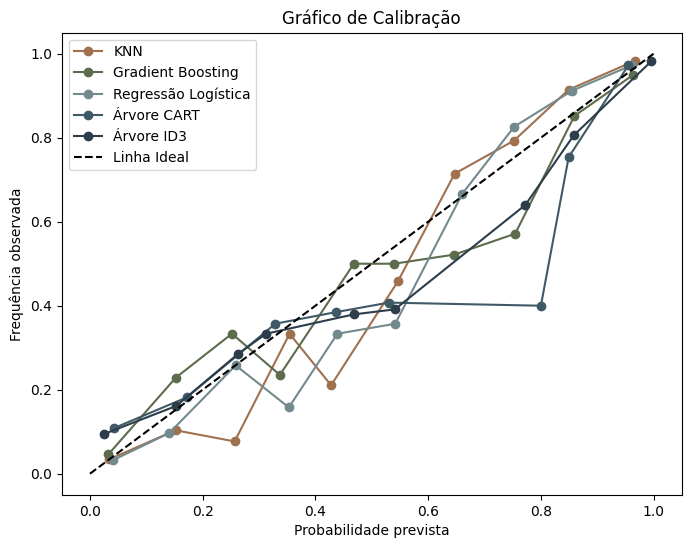

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Sua paleta personalizada
custom_palette = ["#a0714f", "#5c6c4d", "#72898d", "#3f5a66", "#2d3d4b", "#0d1a21"]

plt.figure(figsize=(8, 6))

# Itera sobre os modelos, atribuindo uma cor de acordo com a paleta
for i, (name, model) in enumerate(models1.items()):
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name, color=custom_palette[i % len(custom_palette)])

# Linha de calibração ideal
plt.plot([0, 1], [0, 1], 'k--', label="Linha Ideal")

plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência observada")
plt.title("Gráfico de Calibração")
plt.legend()
plt.show()


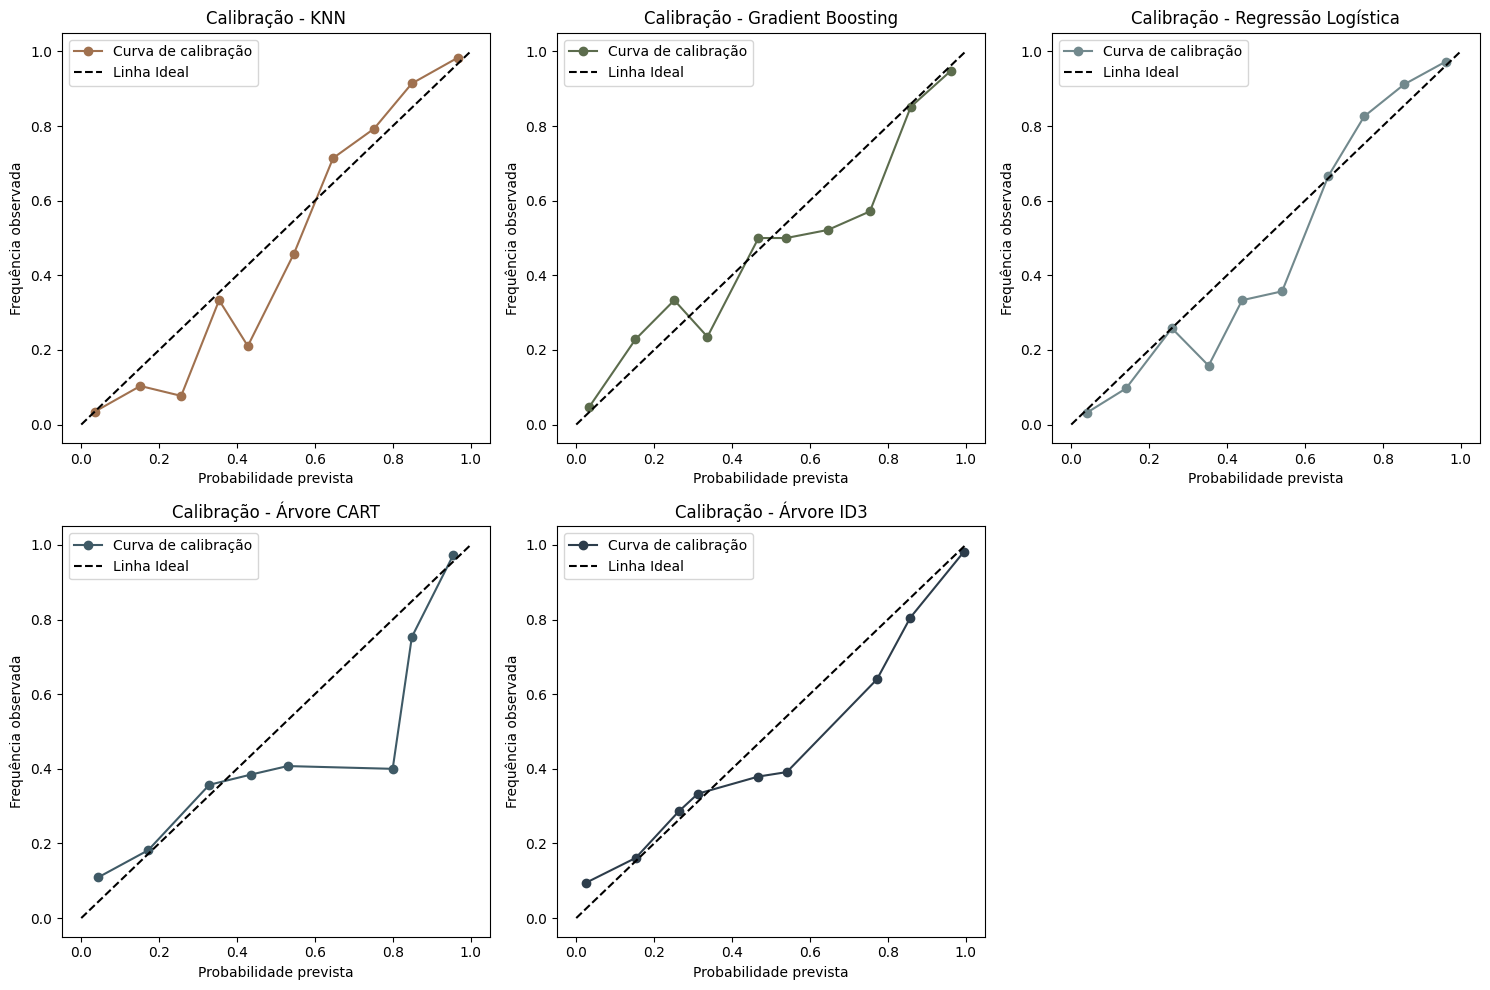

In [ ]:
import math
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Supondo que models1 é o dicionário dos modelos e X_test, y_test estão definidos.
# Sua paleta personalizada
custom_palette = ["#a0714f", "#5c6c4d", "#72898d", "#3f5a66", "#2d3d4b", "#0d1a21"]

# Número de modelos
n_models = len(models1)
ncols = 3  # Número de colunas desejado
nrows = math.ceil(n_models / ncols)

# Criar a figura e os eixos
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()  # Transforma para array unidimensional

# Iterar sobre cada modelo e plotar a curva de calibração
for i, (name, model) in enumerate(models1.items()):
    ax = axes[i]
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

    # Selecionar cor da paleta
    color = custom_palette[i % len(custom_palette)]

    # Plotar a curva de calibração e a linha ideal
    ax.plot(prob_pred, prob_true, marker='o', label="Curva de calibração", color=color)
    ax.plot([0, 1], [0, 1], 'k--', label="Linha Ideal")

    # Configurar rótulos e título
    ax.set_xlabel("Probabilidade prevista")
    ax.set_ylabel("Frequência observada")
    ax.set_title(f"Calibração - {name}")
    ax.legend()

# Remover eixos vazios, se houver
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.calibration import calibration_curve
from plotnine import (
    ggplot, aes, geom_line, geom_point, geom_abline, facet_wrap,
    labs, theme_minimal, theme, element_text, scale_color_manual
)

# Sua paleta personalizada (garanta que há cores suficientes para seus modelos)
custom_palette = ["#a0714f", "#5c6c4d", "#72898d", "#3f5a66", "#2d3d4b", "#0d1a21"]

# Criar um DataFrame para armazenar as curvas de calibração de todos os modelos
df_calib = pd.DataFrame()

# Iterar sobre os modelos e calcular a curva de calibração para cada um
for i, (name, model) in enumerate(models1.items()):
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

    temp_df = pd.DataFrame({
        'Modelo': name,
        'Prob_Pred': prob_pred,
        'Prob_True': prob_true
    })
    df_calib = pd.concat([df_calib, temp_df], ignore_index=True)

# Criar o gráfico com plotnine usando facet_wrap para separar os modelos
p = (
    ggplot(df_calib, aes(x='Prob_Pred', y='Prob_True', color='Modelo'))
    + geom_line()
    + geom_point()
    + geom_abline(intercept=0, slope=1, linetype="dashed", color="black")
    + facet_wrap('~Modelo')  # Cada modelo em um painel
    + scale_color_manual(values=custom_palette[:len(models1)])  # Usar cores da sua paleta
    + labs(title="",
           x="Probabilidade Prevista",
           y="Frequência Observada")
    + theme_minimal()
    + theme(
        strip_text=element_text(size=10, weight='bold'),
        axis_text_x=element_text(rotation=0),
        plot_title=element_text(size=14, weight='bold'),
        figure_size=(10, 8)
    )
)

print(p)


<ggplot: (1000 x 800)>


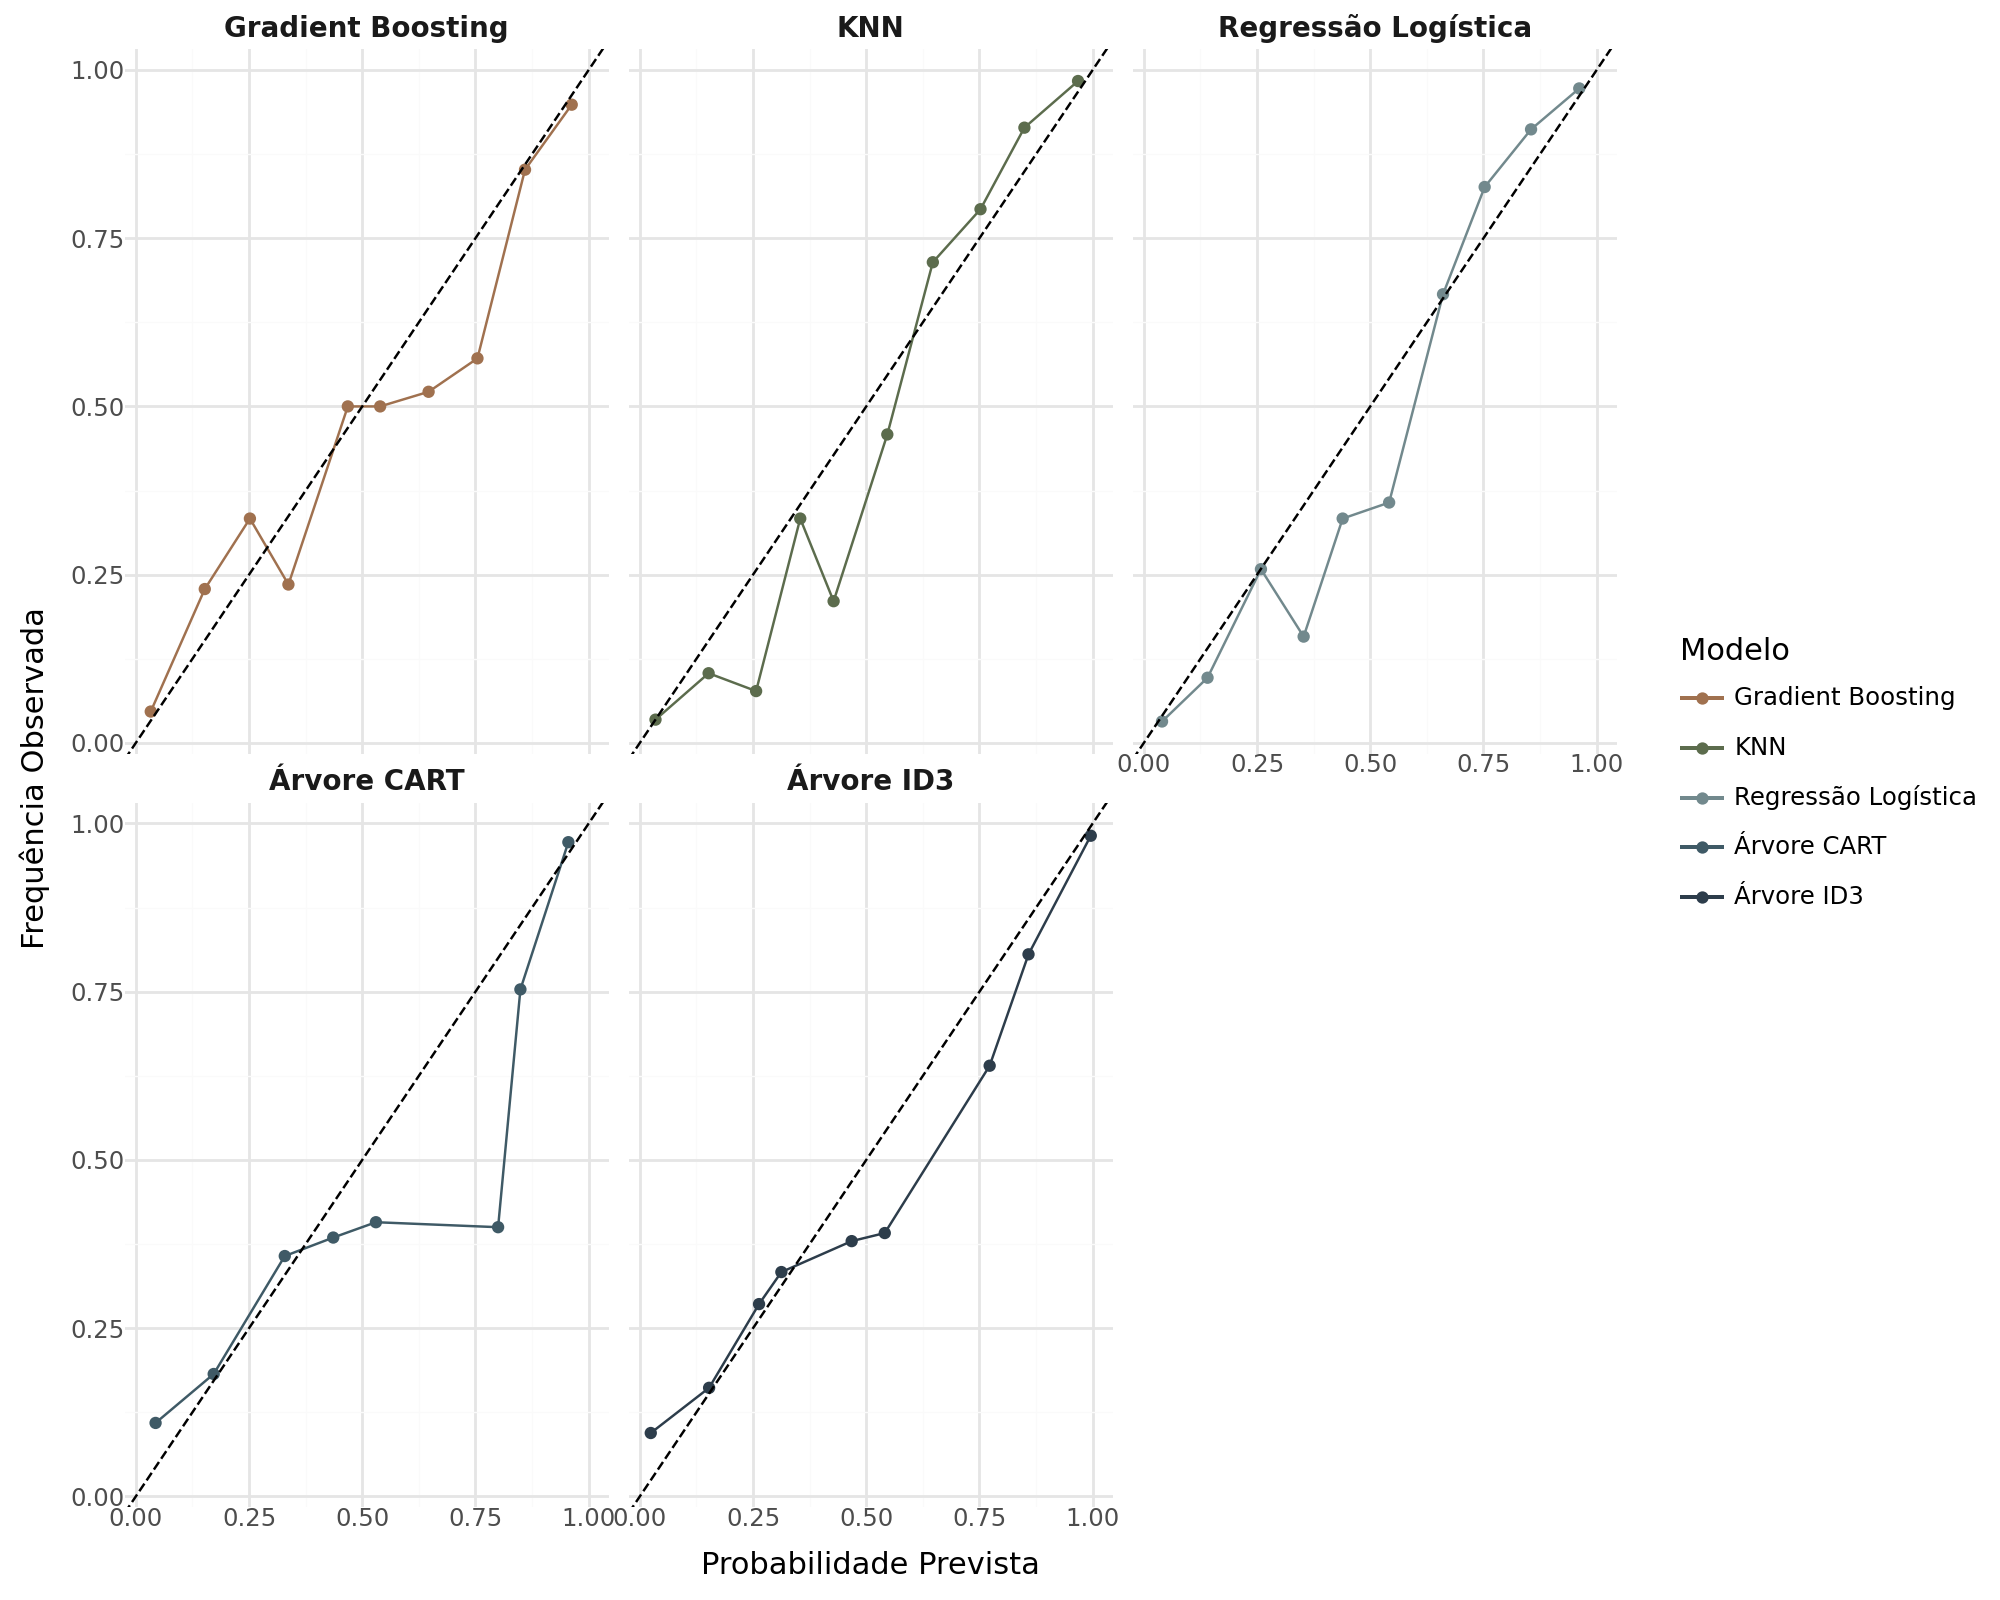

In [ ]:
p

In [ ]:
from plotnine import geom_histogram, after_stat

# Histogramas das probabilidades previstas
p_pred = (
    ggplot(df_calib, aes(x='Prob_Pred', fill='Modelo'))
    + geom_histogram(bins=10, alpha=0.6, position="identity", color="black")
    + facet_wrap('~Modelo')  # Facetas para cada modelo
    + scale_color_manual(values=custom_palette[:len(models1)])
    + scale_fill_manual(values=custom_palette[:len(models1)])  # Aplicar paleta personalizada
    + labs(title="Distribuição das Probabilidades Previstas por Modelo",
           x="Probabilidade Prevista",
           y="Frequência")
    + theme_minimal()
    + theme(
        strip_text=element_text(size=10, weight='bold'),
        axis_text_x=element_text(rotation=0),
        plot_title=element_text(size=14, weight='bold'),
        figure_size=(10, 6)
    )
)

# Histogramas das probabilidades observadas
p_true = (
    ggplot(df_calib, aes(x='Prob_True', fill='Modelo'))
    + geom_histogram(bins=10, alpha=0.6, position="identity", color="black")
    + facet_wrap('~Modelo')  # Facetas para cada modelo
    + scale_color_manual(values=custom_palette[:len(models1)])
    + scale_fill_manual(values=custom_palette[:len(models1)])  # Aplicar paleta personalizada
    + labs(title="Distribuição das Probabilidades Observadas por Modelo",
           x="Probabilidade Observada",
           y="Frequência")
    + theme_minimal()
    + theme(
        strip_text=element_text(size=10, weight='bold'),
        axis_text_x=element_text(rotation=0),
        plot_title=element_text(size=14, weight='bold'),
        figure_size=(10, 6)
    )
)

# Exibir os gráficos
print(p_pred)
print(p_true)


<ggplot: (1000 x 600)>
<ggplot: (1000 x 600)>


/usr/local/lib/python3.11/dist-packages/plotnine/guides/guides.py:211: PlotnineWarning: Cannot generate legend for the 'color' aesthetic. Make sure you have mapped a variable to it


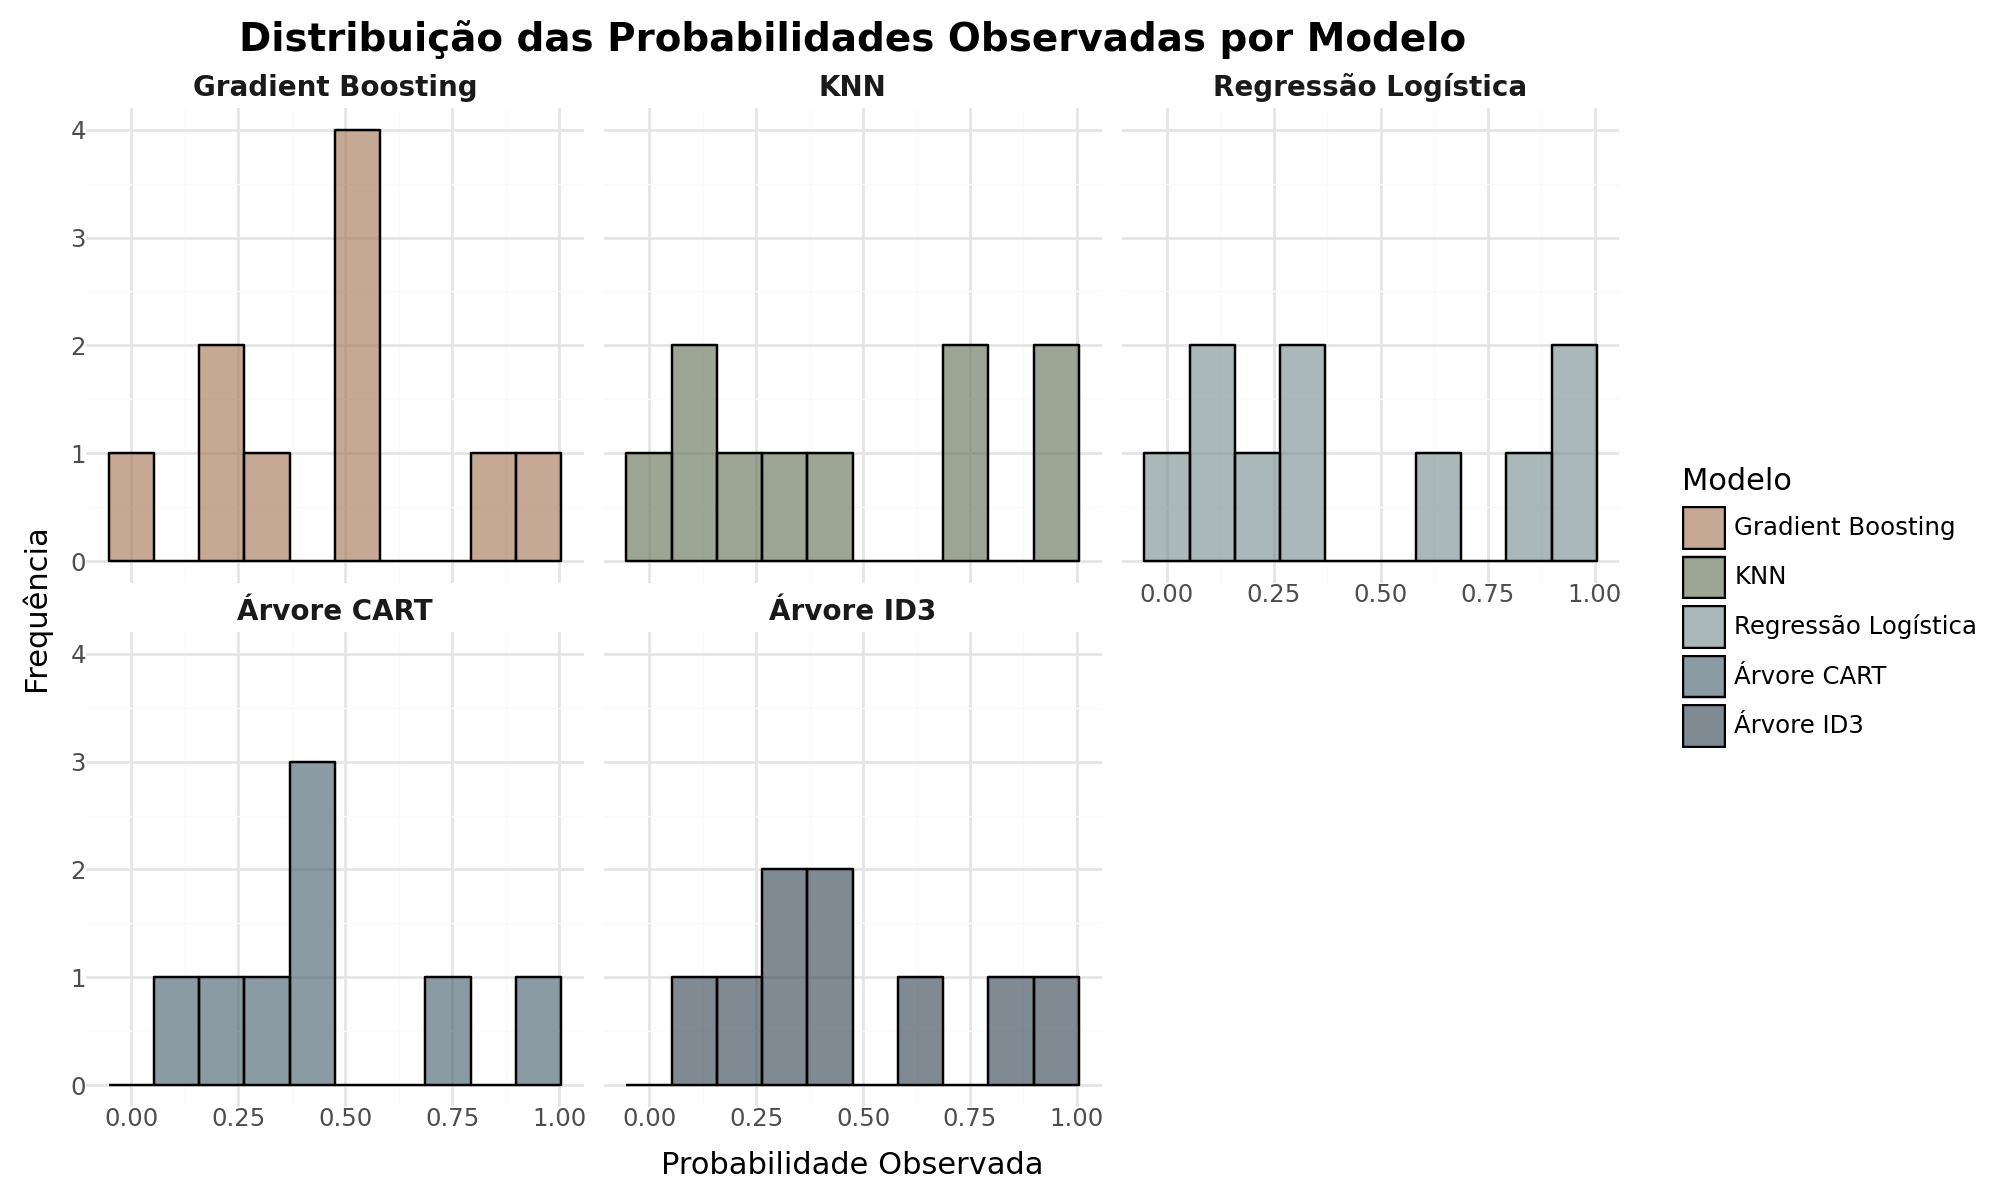

In [ ]:
p_true

                Modelo  Erro Médio  Desvio Padrão
0                  KNN    0.036540       0.093500
1    Gradient Boosting    0.026726       0.082294
2  Regressão Logística    0.039040       0.088728
3          Árvore CART    0.068635       0.139055
4           Árvore ID3    0.035041       0.071176


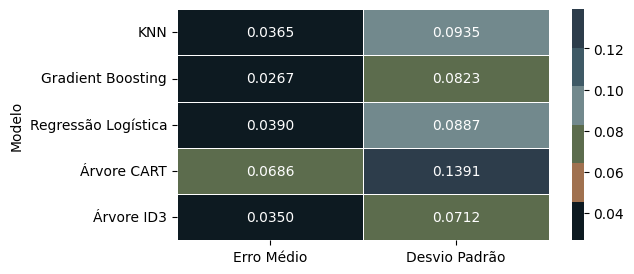

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

custom_palette = ["#0d1a21", "#a0714f", "#5c6c4d", "#72898d", "#3f5a66", "#2d3d4b"]


# Criar um dicionário para armazenar os erros de calibração
calibration_results = {"Modelo": [], "Erro Médio": [], "Desvio Padrão": []}

for name, model in models1.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

    # Calcular erro médio e desvio padrão da calibração
    calibration_error = prob_pred - prob_true
    mean_error = np.mean(calibration_error)
    std_error = np.std(calibration_error)

    # Armazenar os resultados
    calibration_results["Modelo"].append(name)
    calibration_results["Erro Médio"].append(mean_error)
    calibration_results["Desvio Padrão"].append(std_error)

# Criar DataFrame com os resultados
calibration_df = pd.DataFrame(calibration_results)

# Exibir a tabela
print(calibration_df)

# Opcional: plotar a tabela como gráfico
plt.figure(figsize=(6, 3))
sns.heatmap(
    calibration_df.set_index("Modelo"),
    annot=True,
    fmt=".4f",
    cmap=sns.color_palette(custom_palette),  # Usando sua paleta personalizada
    linewidths=0.5  # Aqui estava o erro
)
plt.title("")
plt.show()


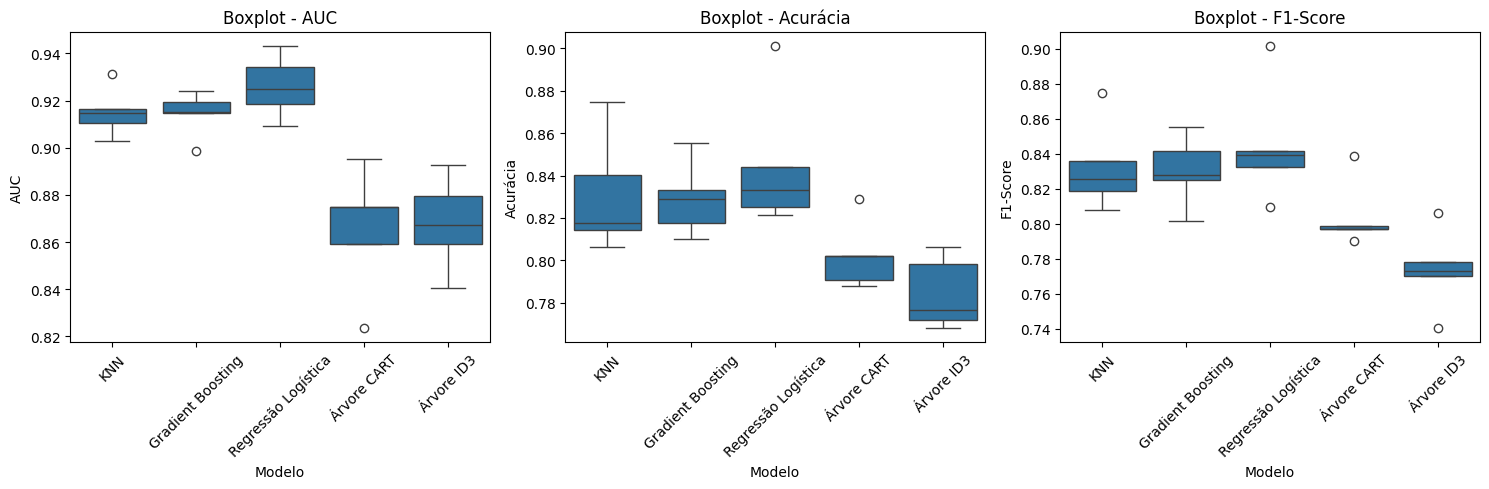

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Dicionário para armazenar as métricas de cada modelo
metrics = {
    'Modelo': [],
    'AUC': [],
    'Acurácia': [],
    'F1-Score': []
}

# Calcular métricas para cada modelo usando validação cruzada
for name, model in models1.items():
    # AUC
    auc_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    # Acurácia
    accuracy_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    # F1-Score
    f1_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

    # Armazenar as métricas
    metrics['Modelo'].extend([name] * 5)  # 5 folds
    metrics['AUC'].extend(auc_scores)
    metrics['Acurácia'].extend(accuracy_scores)
    metrics['F1-Score'].extend(f1_scores)

# Converter para DataFrame
metrics_df = pd.DataFrame(metrics)

# Plotar boxplots para cada métrica
plt.figure(figsize=(15, 5))

# Boxplot para AUC
plt.subplot(1, 3, 1)
sns.boxplot(x='Modelo', y='AUC', data=metrics_df)
plt.title('Boxplot - AUC')
plt.xticks(rotation=45)

# Boxplot para Acurácia
plt.subplot(1, 3, 2)
sns.boxplot(x='Modelo', y='Acurácia', data=metrics_df)
plt.title('Boxplot - Acurácia')
plt.xticks(rotation=45)

# Boxplot para F1-Score
plt.subplot(1, 3, 3)
sns.boxplot(x='Modelo', y='F1-Score', data=metrics_df)
plt.title('Boxplot - F1-Score')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Criando novo ColumnTransformer sem as features
new_preprocessor1 = ColumnTransformer(
    transformers=[
        ('scaler', RobustScaler(), [
            'golddiffat10', 'xpdiffat10', 'csdiffat10',
             'csdiffat15','pick_strength'
        ])
    ]
)

# Criando o novo pipeline
new_model = Pipeline([
    ('preprocessor', new_preprocessor),
    ('model', GradientBoostingClassifier(
        n_estimators=150, learning_rate=0.1,
        max_depth=3, subsample=0.8, random_state=42))
])

# Dividindo os dados (substitua X e y pelos seus dados)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando o modelo sem 'side' e 'patch'
new_model.fit(X_train, y_train)

# Fazendo previsões
y_pred = new_model.predict(X_test)

# Avaliando o desempenho
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia do modelo sem side e patch: {accuracy:.4f}')


Acurácia do modelo sem side e patch: 0.8333


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

models1 = {
    "KNN": Pipeline([
        ('preprocessor', new_preprocessor1),
        ('model', KNeighborsClassifier(n_neighbors=25, weights='distance'))
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', new_preprocessor1),
        ('model', GradientBoostingClassifier(
            n_estimators=150, learning_rate=0.1,
            max_depth=3, subsample=0.8, random_state=42))
    ]),
    "Regressão Logística": Pipeline([
        ('preprocessor', new_preprocessor1),
        ('model', LogisticRegression(
            C=0.1, penalty='l2', solver='saga',
            max_iter=1000, random_state=42))
    ]),
    "Árvore CART": Pipeline([
        ('preprocessor', new_preprocessor1),
        ('model', DecisionTreeClassifier(
            criterion='gini', max_depth=5,
            min_samples_split=20, random_state=42))
    ]),
    "Árvore ID3": Pipeline([
        ('preprocessor', new_preprocessor1),
        ('model', DecisionTreeClassifier(
            criterion='entropy', max_depth=5,
            min_samples_split=20, random_state=42))
    ])
}


In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


# 6. TREINAMENTO E AVALIAÇÃO
# ---------------------------------------------------------------
results = {model: {'AUC_Treino': [], 'AUC_Teste': [], 'Acurácia_Teste': [], 'F1-Score_Teste': []} for model in models}

# Validação cruzada no treino
cv = GroupKFold(n_splits=5)
for name, model in models1.items():
    auc_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train, groups=groups_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_tr, y_tr)
        val_preds = model.predict_proba(X_val)[:,1]
        auc_scores.append(roc_auc_score(y_val, val_preds))

    # Armazenar métricas de treino
    results[name]['AUC_Treino'] = np.mean(auc_scores), np.std(auc_scores)
     # Avaliação final no teste
    model.fit(X_train, y_train)
    test_preds = model.predict_proba(X_test)[:,1]
    results[name]['AUC_Teste'] = roc_auc_score(y_test, test_preds)
    results[name]['Acurácia_Teste'] = accuracy_score(y_test, (test_preds >= 0.5))
    results[name]['F1-Score_Teste'] = f1_score(y_test, (test_preds >= 0.5))

In [ ]:
# Exibir resultados
print("=== Desempenho dos Modelos ===")
for name, metrics in results.items():
    print(f"\nModelo: {name}")
    print(f"AUC (Treino): {metrics['AUC_Treino'][0]:.3f} ± {metrics['AUC_Treino'][1]:.3f}")
    print(f"AUC (Teste): {metrics['AUC_Teste']:.3f}")
    print(f"Acurácia (Teste): {metrics['Acurácia_Teste']:.2%}")
    print(f"F1-Score (Teste): {metrics['F1-Score_Teste']:.3f}")

=== Desempenho dos Modelos ===

Modelo: KNN
AUC (Treino): 0.856 ± 0.020
AUC (Teste): 0.872
Acurácia (Teste): 79.09%
F1-Score (Teste): 0.794

Modelo: Gradient Boosting
AUC (Treino): 0.837 ± 0.014
AUC (Teste): 0.849
Acurácia (Teste): 76.06%
F1-Score (Teste): 0.766

Modelo: Regressão Logística
AUC (Treino): 0.867 ± 0.017
AUC (Teste): 0.868
Acurácia (Teste): 78.18%
F1-Score (Teste): 0.784

Modelo: Árvore CART
AUC (Treino): 0.812 ± 0.015
AUC (Teste): 0.804
Acurácia (Teste): 75.15%
F1-Score (Teste): 0.752

Modelo: Árvore ID3
AUC (Treino): 0.808 ± 0.019
AUC (Teste): 0.800
Acurácia (Teste): 74.85%
F1-Score (Teste): 0.752


In [ ]:
# Fazendo previsões com o modelo original
y_pred_original = models["Gradient Boosting"].predict(X_test)

# Calculando a acurácia
accuracy_original = accuracy_score(y_test, y_pred_original)
print(f'Acurácia do modelo original: {accuracy_original:.4f}')


Acurácia do modelo original: 0.9212


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def test_feature_removal(features_to_remove):
    remaining_features = [
        'golddiffat10', 'xpdiffat10', 'csdiffat10',
        'golddiffat15', 'xpdiffat15', 'csdiffat15',
        'pick_strength', 'ban_strength', 'side', 'patch'
    ]

    # Remove as features indesejadas
    for feature in features_to_remove:
        if feature in remaining_features:
            remaining_features.remove(feature)

    # Criando novo ColumnTransformer
    new_preprocessor = ColumnTransformer(
        transformers=[('scaler', RobustScaler(), remaining_features)])

    # Criando o pipeline
    new_model = Pipeline([
        ('preprocessor', new_preprocessor),
        ('model', GradientBoostingClassifier(
            n_estimators=150, learning_rate=0.1,
            max_depth=3, subsample=0.8, random_state=42))
    ])

    # Treinando o modelo
    new_model.fit(X_train, y_train)
    y_pred = new_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Avaliar diferentes remoções
a_original = accuracy_score(y_test, models["Gradient Boosting"].predict(X_test))
a_no_side = test_feature_removal(['side'])
a_no_patch = test_feature_removal(['patch'])
a_no_side_patch = test_feature_removal(['side', 'patch'])

# Exibir resultados
print(f'Acurácia do modelo original: {a_original:.4f}')
print(f'Acurácia sem side: {a_no_side:.4f}')
print(f'Acurácia sem patch: {a_no_patch:.4f}')
print(f'Acurácia sem side e patch: {a_no_side_patch:.4f}')


NotFittedError: Pipeline is not fitted yet.

In [ ]:
import pandas as pd

# Criar um DataFrame só com as features usadas
X_used = X_train[['golddiffat10', 'xpdiffat10', 'csdiffat10',
                  'golddiffat15', 'xpdiffat15', 'csdiffat15',
                  'pick_strength', 'ban_strength', 'side', 'patch']]

# Adicionar y ao DataFrame
df_corr = X_used.copy()
df_corr['target'] = y_train  # Supondo que y_train seja a variável de saída

# Calcular correlação
correlations = df_corr.corr()['target'].sort_values(ascending=False)
print(correlations)


target           1.000000
golddiffat15     0.542766
xpdiffat15       0.494546
ban_strength     0.489592
pick_strength    0.487083
csdiffat15       0.450262
xpdiffat10       0.436446
golddiffat10     0.425251
csdiffat10       0.401510
side             0.094223
patch            0.020811
Name: target, dtype: float64


In [ ]:
# Criar um novo pré-processador sem as features removidas
preprocessor_filtered = ColumnTransformer(transformers=[
    ('scaler', RobustScaler(), ['golddiffat10', 'xpdiffat10', 'csdiffat10',
                                 'csdiffat15', 'pick_strength']),  # Removemos as suspeitas
    ('onehot', OneHotEncoder(drop='first'), ['side', 'patch'])
])

# Criar o novo pipeline com o modelo filtrado
modelo_filtrado = Pipeline([
    ('preprocessor', preprocessor_filtered),
    ('model', GradientBoostingClassifier(
        n_estimators=150, learning_rate=0.1,
        max_depth=3, subsample=0.8, random_state=42))
])

# Treinar o modelo novamente
modelo_filtrado.fit(X_train, y_train)

# Testar no conjunto de validação
acc_filtrado = modelo_filtrado.score(X_val, y_val)

print("Acurácia do modelo filtrado:", acc_filtrado)


Acurácia do modelo filtrado: 0.9198473282442748


In [ ]:
feature_names = preprocessor_filtered.get_feature_names_out()
# Criar DataFrame com dados pré-processados
preprocessed_df = pd.DataFrame(
    preprocessor_filtered.transform(X_train),
    columns=feature_names)

In [ ]:
# Dicionário de modelos com o novo pré-processador
models = {
    "KNN": Pipeline([
        ('preprocessor', preprocessor_filtered),
        ('model', KNeighborsClassifier(n_neighbors=25, weights='distance'))
    ]),
    "Gradient Boosting": Pipeline([
        ('preprocessor', preprocessor_filtered),
        ('model', GradientBoostingClassifier(
            n_estimators=150, learning_rate=0.1,
            max_depth=3, subsample=0.8, random_state=42))
    ]),
    "Regressão Logística": Pipeline([
        ('preprocessor', preprocessor_filtered),
        ('model', LogisticRegression(
            C=0.1, penalty='l2', solver='saga',
            max_iter=1000, random_state=42))
    ]),
    "Árvore CART": Pipeline([
        ('preprocessor', preprocessor_filtered),
        ('model', DecisionTreeClassifier(
            criterion='gini', max_depth=5,
            min_samples_split=20, random_state=42))
    ]),
    "Árvore ID3": Pipeline([
        ('preprocessor', preprocessor_filtered),
        ('model', DecisionTreeClassifier(
            criterion='entropy', max_depth=5,
            min_samples_split=20, random_state=42))
    ])
}

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import numpy as np

# 6. TREINAMENTO E AVALIAÇÃO
# ---------------------------------------------------------------
results = {model: {'AUC_Treino': [], 'AUC_Teste': [], 'Acurácia_Teste': [], 'F1-Score_Teste': []} for model in models}

# Validação cruzada no treino
cv = GroupKFold(n_splits=5)
for name, model in models.items():
    auc_scores = []
    for train_idx, val_idx in cv.split(X_train, y_train, groups=groups_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Treinando o modelo no conjunto de treino
        model.fit(X_tr, y_tr)
        val_preds = model.predict_proba(X_val)[:, 1]  # Prevendo probabilidades para AUC
        auc_scores.append(roc_auc_score(y_val, val_preds))

    # Armazenar métricas de treino
    results[name]['AUC_Treino'] = np.mean(auc_scores), np.std(auc_scores)

    # Avaliação final no conjunto de teste
    model.fit(X_train, y_train)
    test_preds = model.predict_proba(X_test)[:, 1]
    results[name]['AUC_Teste'] = roc_auc_score(y_test, test_preds)
    results[name]['Acurácia_Teste'] = accuracy_score(y_test, (test_preds >= 0.5))
    results[name]['F1-Score_Teste'] = f1_score(y_test, (test_preds >= 0.5))

# Exibir resultados
print("=== Desempenho dos Modelos ===")
for name, metrics in results.items():
    print(f"\nModelo: {name}")
    print(f"AUC (Treino): {metrics['AUC_Treino'][0]:.3f} ± {metrics['AUC_Treino'][1]:.3f}")
    print(f"AUC (Teste): {metrics['AUC_Teste']:.3f}")
    print(f"Acurácia (Teste): {metrics['Acurácia_Teste']:.2%}")
    print(f"F1-Score (Teste): {metrics['F1-Score_Teste']:.3f}")

=== Desempenho dos Modelos ===

Modelo: KNN
AUC (Treino): 0.852 ± 0.019
AUC (Teste): 0.849
Acurácia (Teste): 74.55%
F1-Score (Teste): 0.756

Modelo: Gradient Boosting
AUC (Treino): 0.839 ± 0.014
AUC (Teste): 0.854
Acurácia (Teste): 75.45%
F1-Score (Teste): 0.761

Modelo: Regressão Logística
AUC (Treino): 0.868 ± 0.016
AUC (Teste): 0.867
Acurácia (Teste): 78.18%
F1-Score (Teste): 0.784

Modelo: Árvore CART
AUC (Treino): 0.810 ± 0.015
AUC (Teste): 0.804
Acurácia (Teste): 75.15%
F1-Score (Teste): 0.752

Modelo: Árvore ID3
AUC (Treino): 0.808 ± 0.019
AUC (Teste): 0.800
Acurácia (Teste): 74.85%
F1-Score (Teste): 0.752


In [ ]:
model = models["Gradient Boosting"].named_steps['model']
importances = model.feature_importances_

# Exibir as importâncias com os nomes das features
feature_names = ['golddiffat10', 'xpdiffat10', 'csdiffat10', 'pick_strength', 'side', 'patch']
for name, importance in zip(feature_names, importances):
    print(f"Feature: {name}, Importance: {importance}")


Feature: golddiffat10, Importance: 0.15287088228848963
Feature: xpdiffat10, Importance: 0.11941063468085704
Feature: csdiffat10, Importance: 0.08411153623744232
Feature: pick_strength, Importance: 0.1967474391039344
Feature: side, Importance: 0.4287624712794252
Feature: patch, Importance: 0.007305290823144938


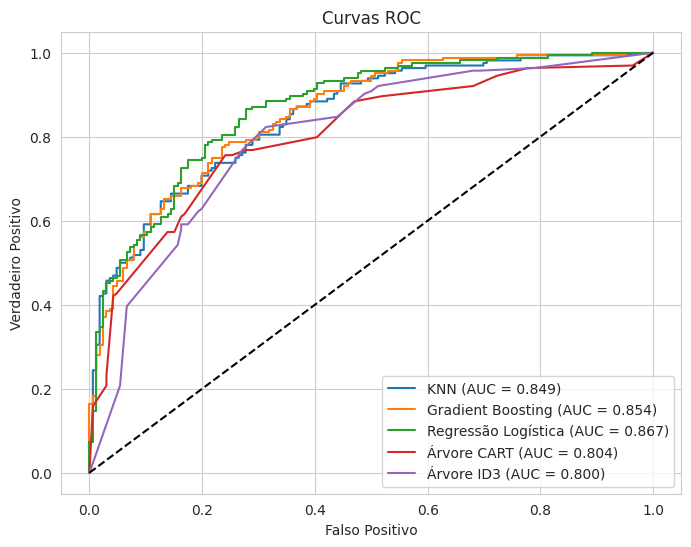

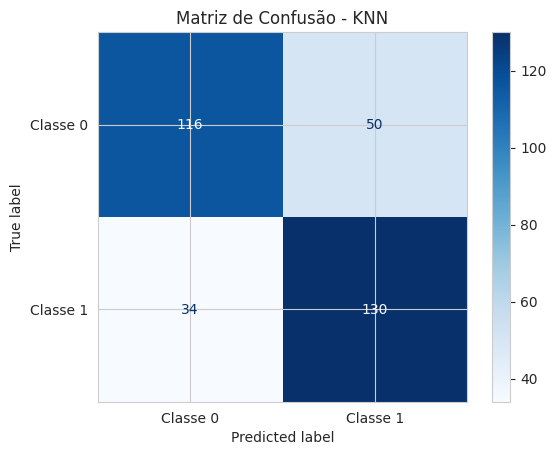

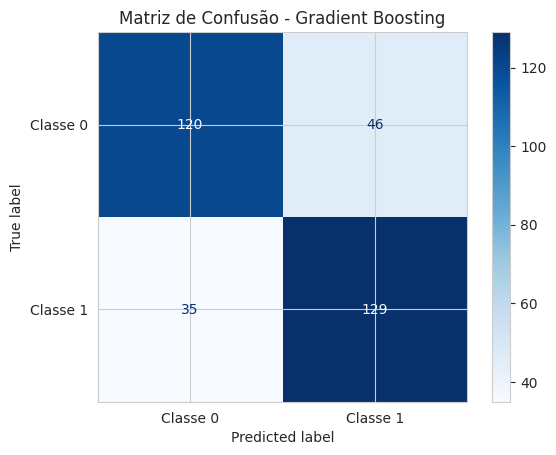

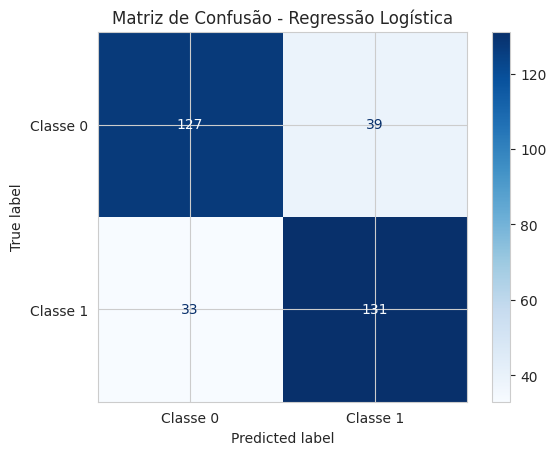

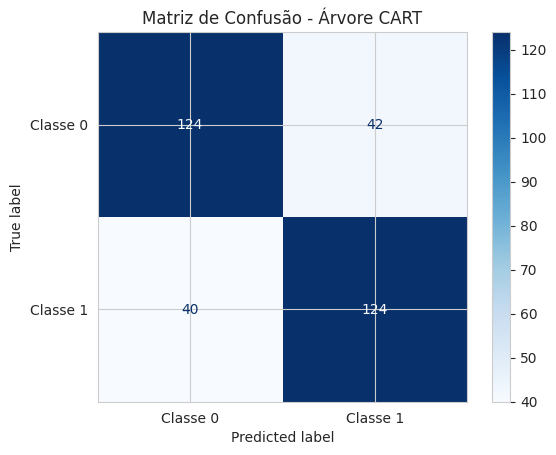

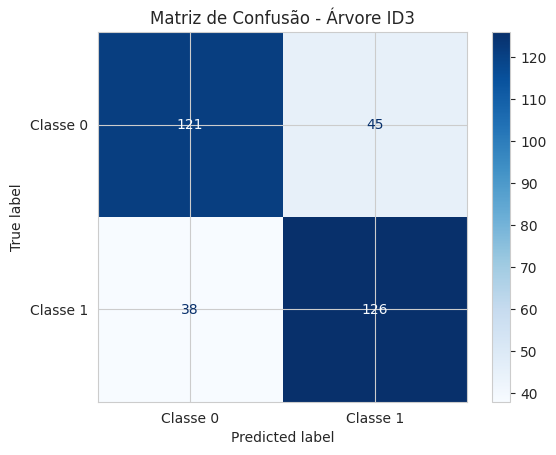

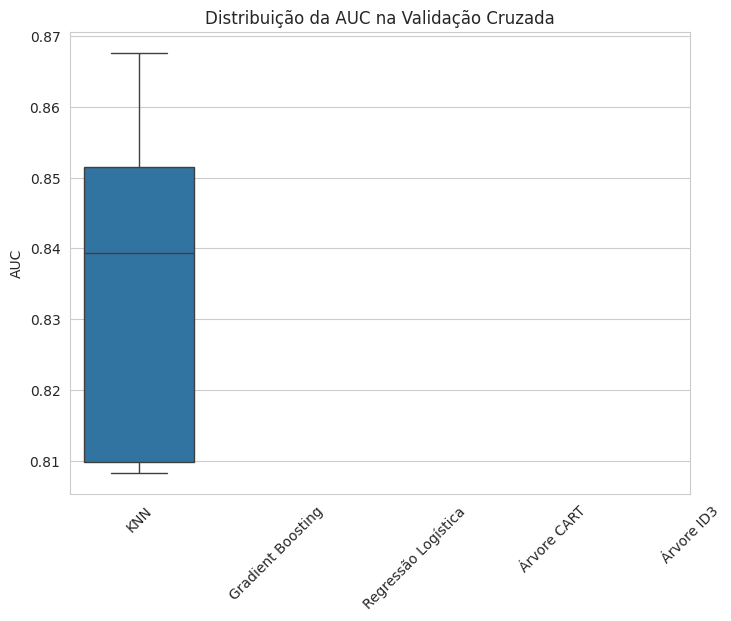

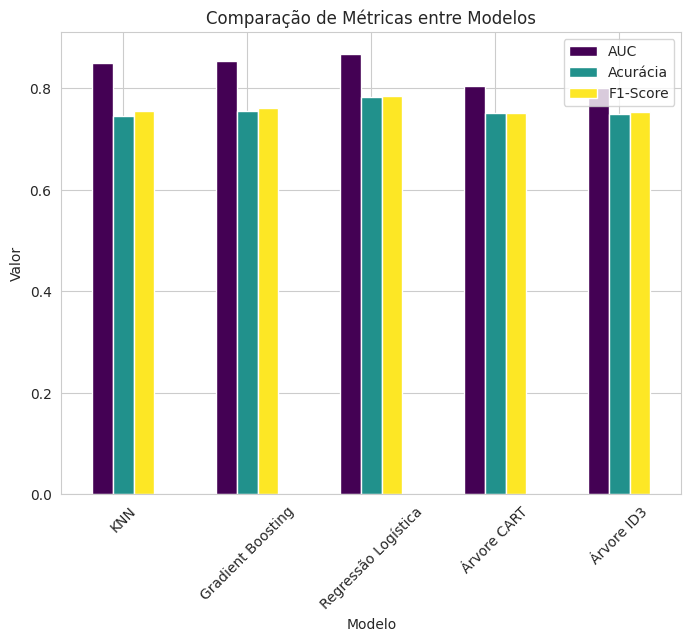

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Configuração geral de estilo
sns.set_style("whitegrid")

# Curvas ROC
plt.figure(figsize=(8, 6))
for name, model in models.items():
    test_preds = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, test_preds)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # Linha do azar
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curvas ROC')
plt.legend()
plt.show()

# Matrizes de Confusão
for name, model in models.items():
    y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Classe 0", "Classe 1"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

# Importância das Features (Apenas para Gradient Boosting e Regressão Logística)
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_).flatten()
    else:
        continue  # Modelos sem feature importance

    feature_names = ['golddiffat10', 'xpdiffat10', 'csdiffat10', 'pick_strength', 'side', 'patch']
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(importances)), importances[sorted_idx], tick_label=np.array(feature_names)[sorted_idx])
    plt.xticks(rotation=90)
    plt.title(f'Importância das Features - {name}')
    plt.show()

# Boxplots das Métricas (AUC na validação cruzada)
plt.figure(figsize=(8, 6))
auc_values = [results[model]['AUC_Treino'][0] for model in models]
sns.boxplot(data=auc_values)
plt.xticks(range(len(models)), models.keys(), rotation=45)
plt.title("Distribuição da AUC na Validação Cruzada")
plt.ylabel("AUC")
plt.show()

# Comparação das métricas entre modelos
metrics_df = {
    "Modelo": list(models.keys()),
    "AUC": [results[model]['AUC_Teste'] for model in models],
    "Acurácia": [results[model]['Acurácia_Teste'] for model in models],
    "F1-Score": [results[model]['F1-Score_Teste'] for model in models]
}
metrics_df = pd.DataFrame(metrics_df)
metrics_df.set_index("Modelo").plot(kind='bar', figsize=(8, 6), colormap='viridis')
plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()


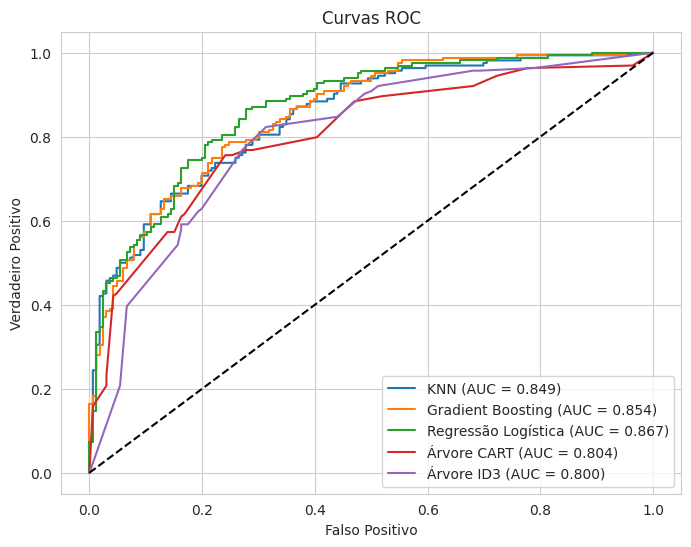

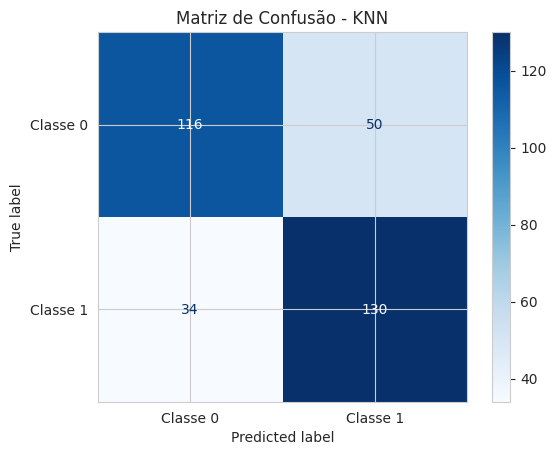

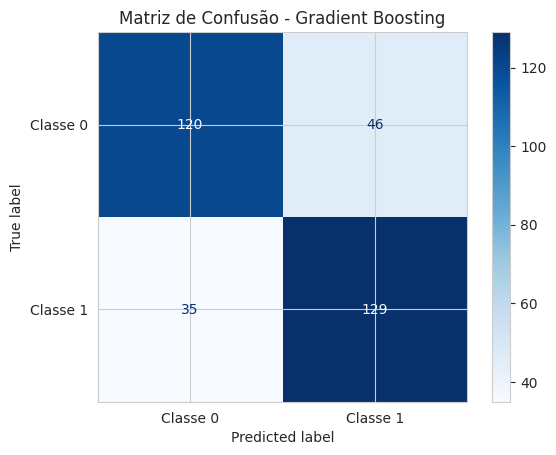

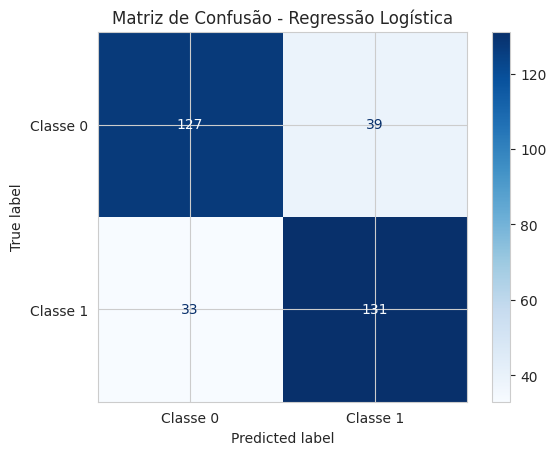

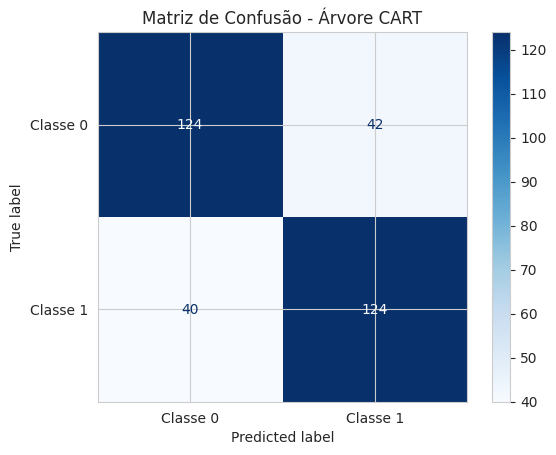

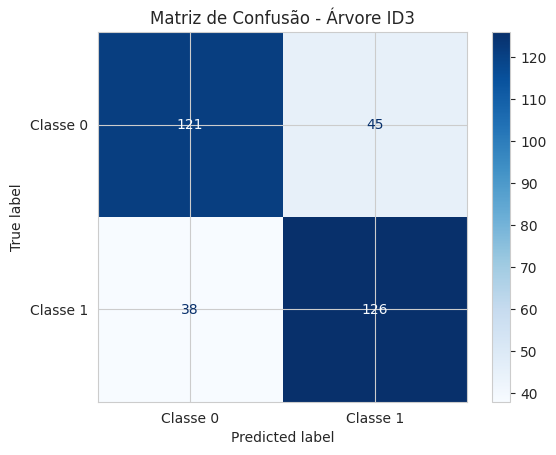

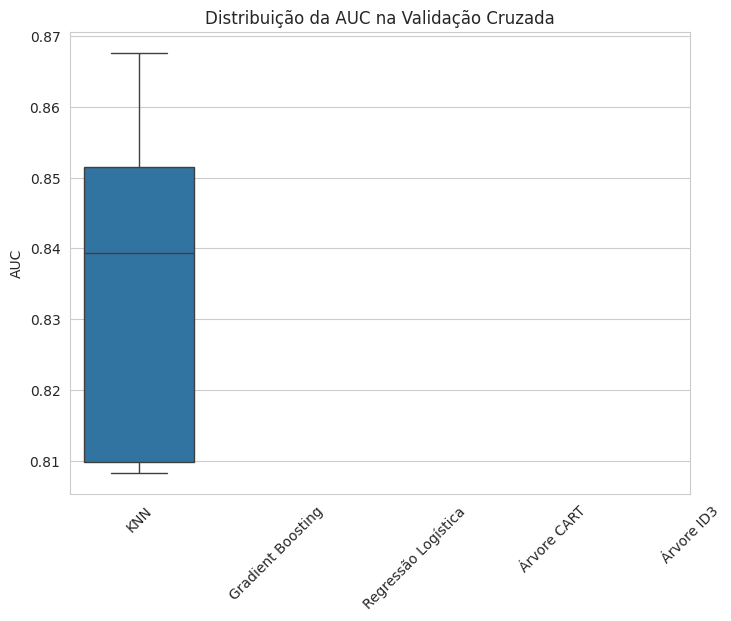

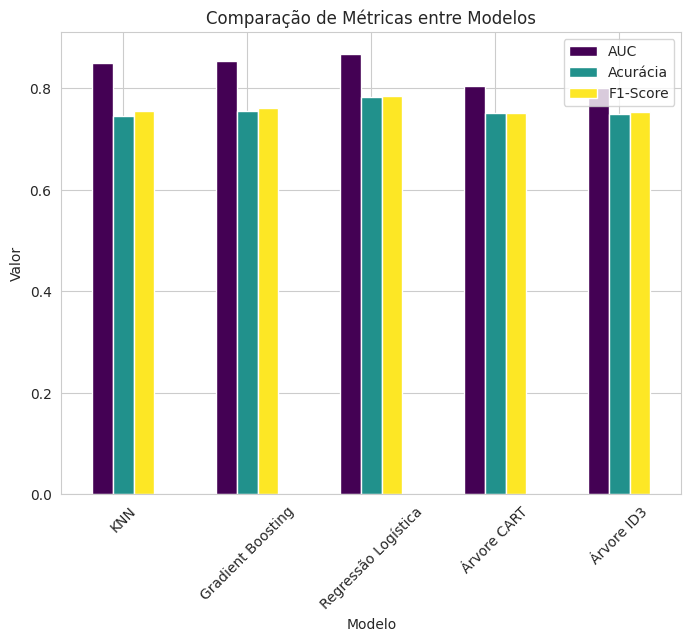

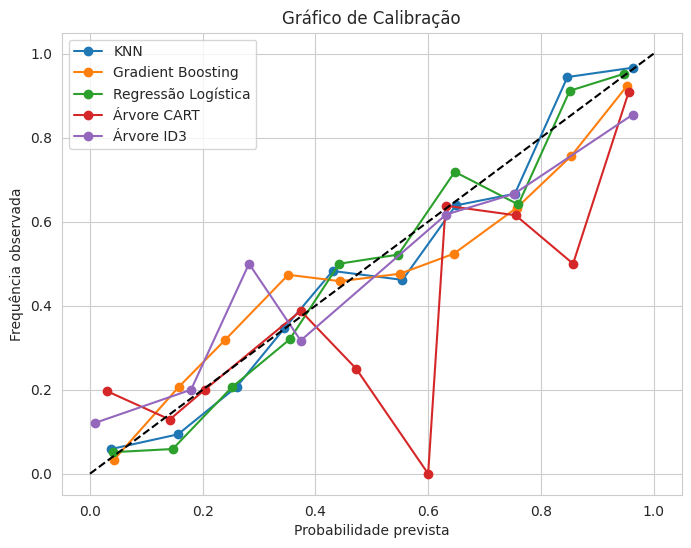

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

# Configuração geral de estilo
sns.set_style("whitegrid")

# Curvas ROC
plt.figure(figsize=(8, 6))
for name, model in models.items():
    test_preds = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, test_preds)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # Linha do azar
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curvas ROC')
plt.legend()
plt.show()

# Matrizes de Confusão
for name, model in models.items():
    y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Classe 0", "Classe 1"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

# Importância das Features (Apenas para Gradient Boosting e Regressão Logística)
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_).flatten()
    else:
        continue  # Modelos sem feature importance

    feature_names = ['golddiffat10', 'xpdiffat10', 'csdiffat10', 'pick_strength', 'side', 'patch']
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(importances)), importances[sorted_idx], tick_label=np.array(feature_names)[sorted_idx])
    plt.xticks(rotation=90)
    plt.title(f'Importância das Features - {name}')
    plt.show()

# Boxplots das Métricas (AUC na validação cruzada)
plt.figure(figsize=(8, 6))
auc_values = [results[model]['AUC_Treino'][0] for model in models]
sns.boxplot(data=auc_values)
plt.xticks(range(len(models)), models.keys(), rotation=45)
plt.title("Distribuição da AUC na Validação Cruzada")
plt.ylabel("AUC")
plt.show()

# Comparação das métricas entre modelos
metrics_df = {
    "Modelo": list(models.keys()),
    "AUC": [results[model]['AUC_Teste'] for model in models],
    "Acurácia": [results[model]['Acurácia_Teste'] for model in models],
    "F1-Score": [results[model]['F1-Score_Teste'] for model in models]
}
metrics_df = pd.DataFrame(metrics_df)
metrics_df.set_index("Modelo").plot(kind='bar', figsize=(8, 6), colormap='viridis')
plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

# Gráfico de Calibração
plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=name)

plt.plot([0, 1], [0, 1], 'k--')  # Linha ideal de calibração
plt.xlabel("Probabilidade prevista")
plt.ylabel("Frequência observada")
plt.title("Gráfico de Calibração")
plt.legend()
plt.show()


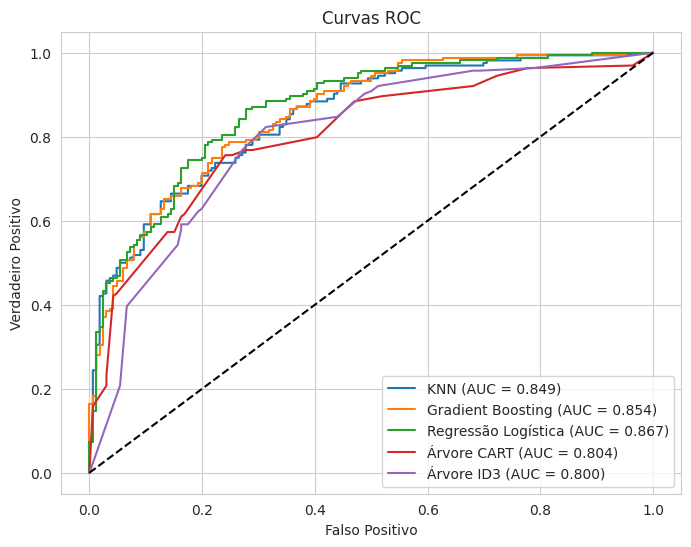

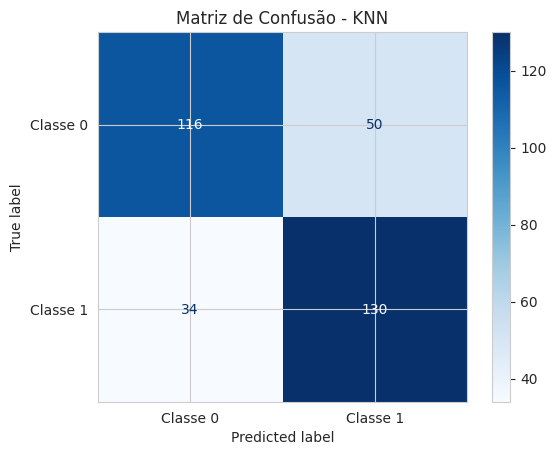

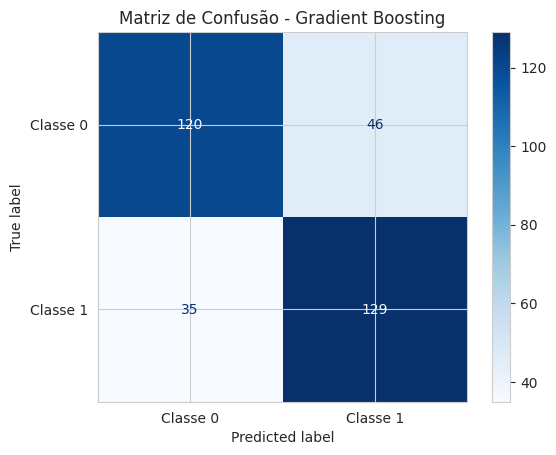

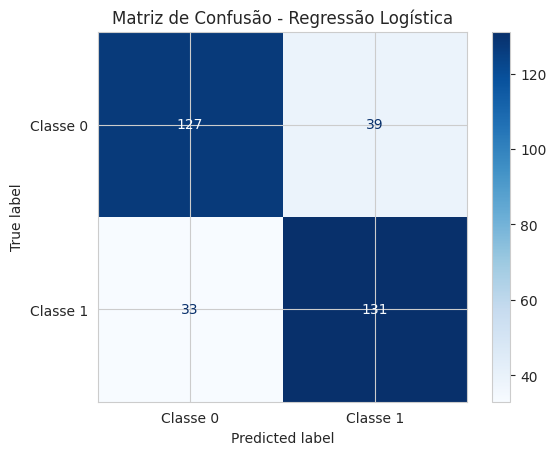

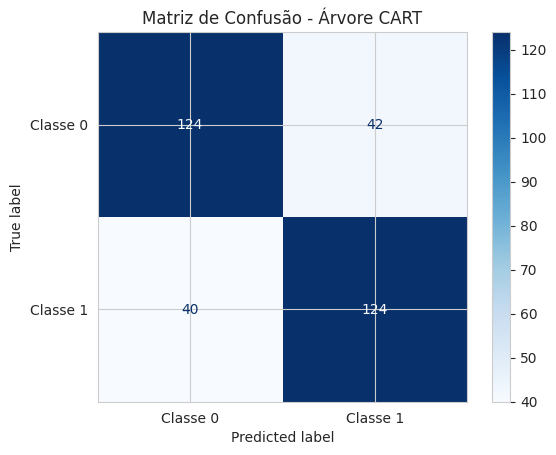

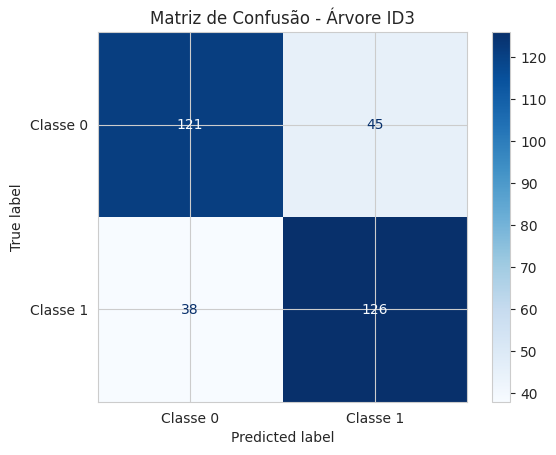

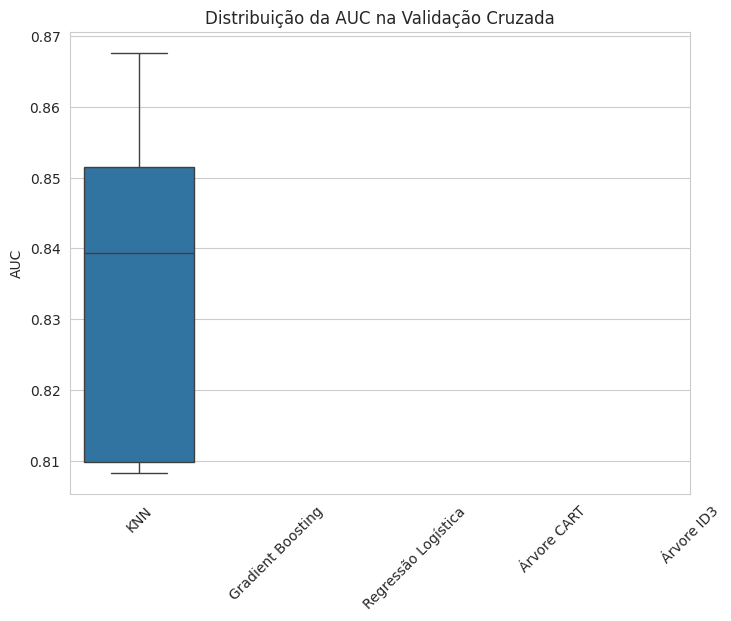

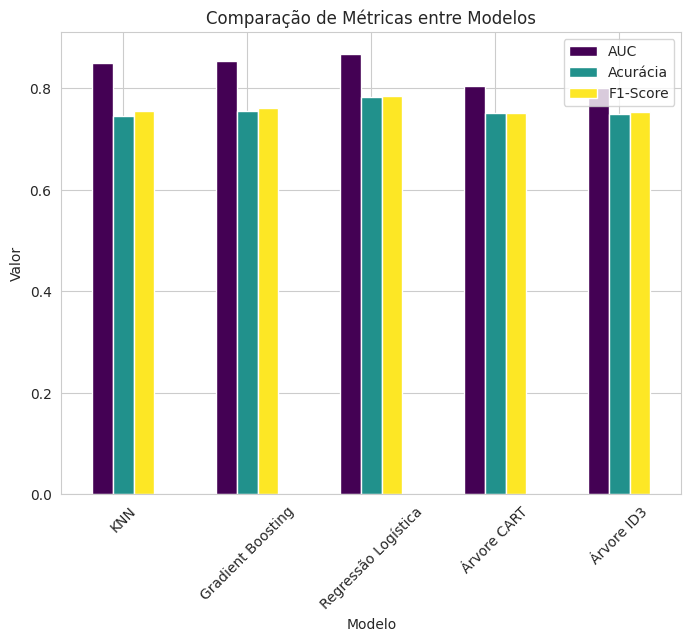

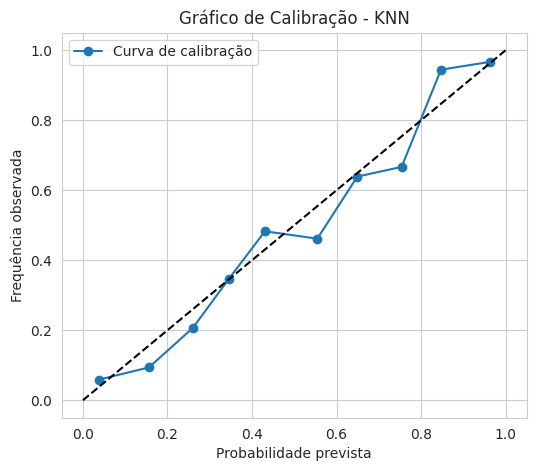

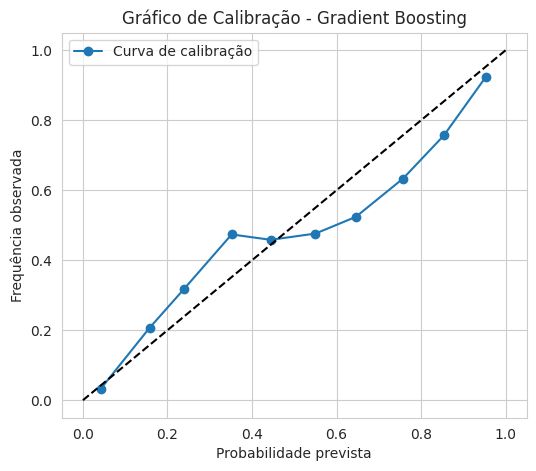

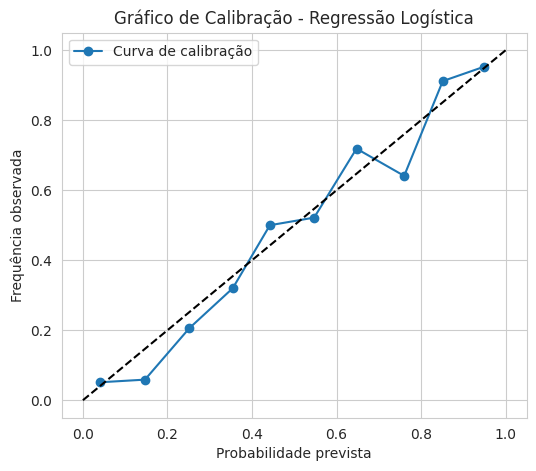

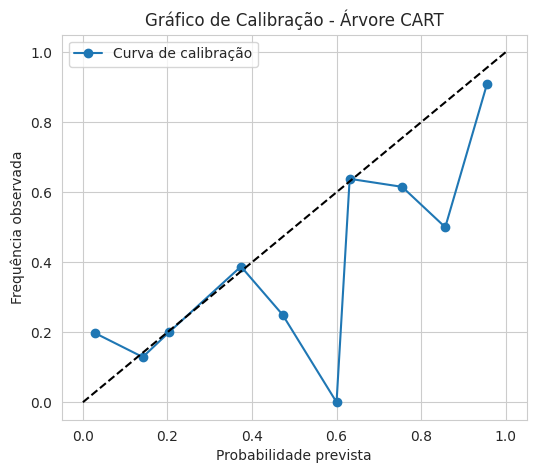

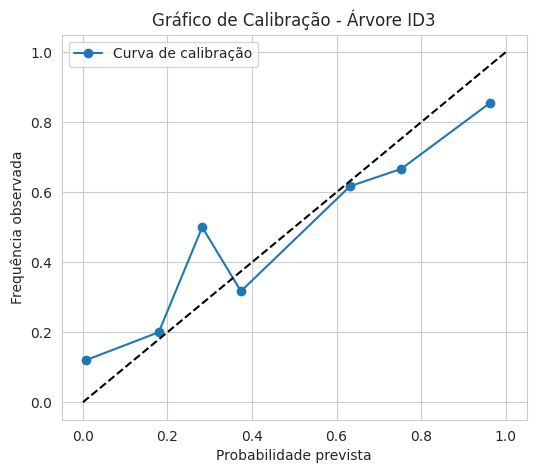

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.calibration import calibration_curve

# Configuração geral de estilo
sns.set_style("whitegrid")

# Curvas ROC
plt.figure(figsize=(8, 6))
for name, model in models.items():
    test_preds = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, test_preds)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc(fpr, tpr):.3f})')

plt.plot([0, 1], [0, 1], 'k--')  # Linha do azar
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curvas ROC')
plt.legend()
plt.show()

# Matrizes de Confusão
for name, model in models.items():
    y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Classe 0", "Classe 1"])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de Confusão - {name}')
    plt.show()

# Importância das Features (Apenas para Gradient Boosting e Regressão Logística)
for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_).flatten()
    else:
        continue  # Modelos sem feature importance

    feature_names = ['golddiffat10', 'xpdiffat10', 'csdiffat10', 'pick_strength', 'side', 'patch']
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 5))
    plt.bar(range(len(importances)), importances[sorted_idx], tick_label=np.array(feature_names)[sorted_idx])
    plt.xticks(rotation=90)
    plt.title(f'Importância das Features - {name}')
    plt.show()

# Boxplots das Métricas (AUC na validação cruzada)
plt.figure(figsize=(8, 6))
auc_values = [results[model]['AUC_Treino'][0] for model in models]
sns.boxplot(data=auc_values)
plt.xticks(range(len(models)), models.keys(), rotation=45)
plt.title("Distribuição da AUC na Validação Cruzada")
plt.ylabel("AUC")
plt.show()

# Comparação das métricas entre modelos
metrics_df = {
    "Modelo": list(models.keys()),
    "AUC": [results[model]['AUC_Teste'] for model in models],
    "Acurácia": [results[model]['Acurácia_Teste'] for model in models],
    "F1-Score": [results[model]['F1-Score_Teste'] for model in models]
}
metrics_df = pd.DataFrame(metrics_df)
metrics_df.set_index("Modelo").plot(kind='bar', figsize=(8, 6), colormap='viridis')
plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Valor")
plt.xticks(rotation=45)
plt.show()

# Gráficos de Calibração Individuais
for name, model in models.items():
    plt.figure(figsize=(6, 5))
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

    plt.plot(prob_pred, prob_true, marker='o', label="Curva de calibração")
    plt.plot([0, 1], [0, 1], 'k--')  # Linha ideal de calibração

    plt.xlabel("Probabilidade prevista")
    plt.ylabel("Frequência observada")
    plt.title(f"Gráfico de Calibração - {name}")
    plt.legend()
    plt.show()


                Modelo  Erro Médio  Desvio Padrão
0                  KNN    0.013041       0.058357
1    Gradient Boosting    0.019171       0.081273
2  Regressão Logística    0.010765       0.060748
3          Árvore CART    0.119461       0.210838
4           Árvore ID3   -0.012130       0.108237


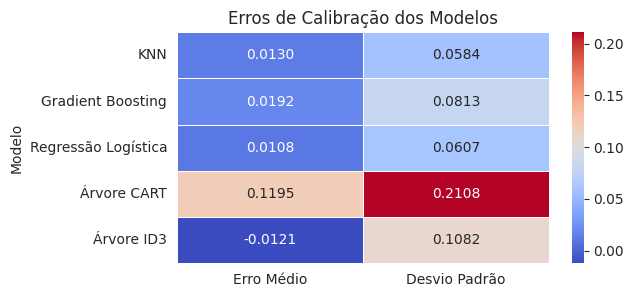

In [ ]:
from sklearn.calibration import calibration_curve

# Criar um dicionário para armazenar os erros de calibração
calibration_results = {"Modelo": [], "Erro Médio": [], "Desvio Padrão": []}

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

    # Calcular erro médio e desvio padrão da calibração
    calibration_error = prob_pred - prob_true
    mean_error = np.mean(calibration_error)
    std_error = np.std(calibration_error)

    # Armazenar os resultados
    calibration_results["Modelo"].append(name)
    calibration_results["Erro Médio"].append(mean_error)
    calibration_results["Desvio Padrão"].append(std_error)

# Criar DataFrame com os resultados
calibration_df = pd.DataFrame(calibration_results)

# Exibir a tabela
print(calibration_df)

# Opcional: plotar a tabela como gráfico
plt.figure(figsize=(6, 3))
sns.heatmap(
    calibration_df.set_index("Modelo"),
    annot=True,
    fmt=".4f",
    cmap="coolwarm",
    linewidths=0.5  # Aqui estava o erro
)
plt.title("Erros de Calibração dos Modelos")
plt.show()


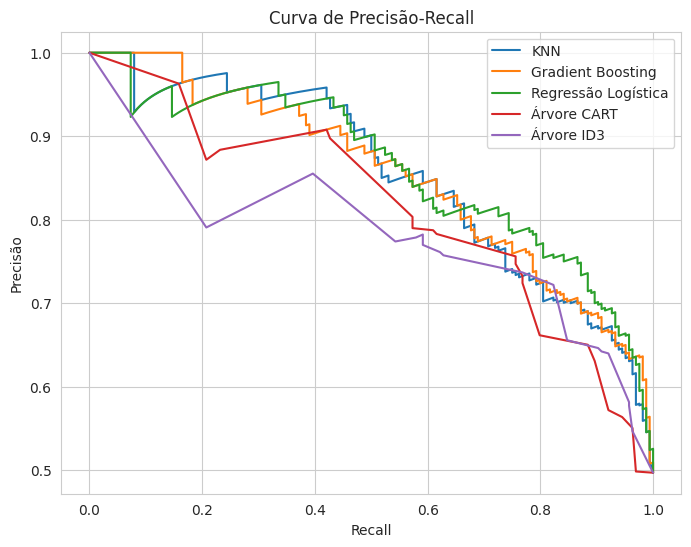

In [ ]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recall, precision, label=f'{name}')

plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva de Precisão-Recall")
plt.legend()
plt.show()


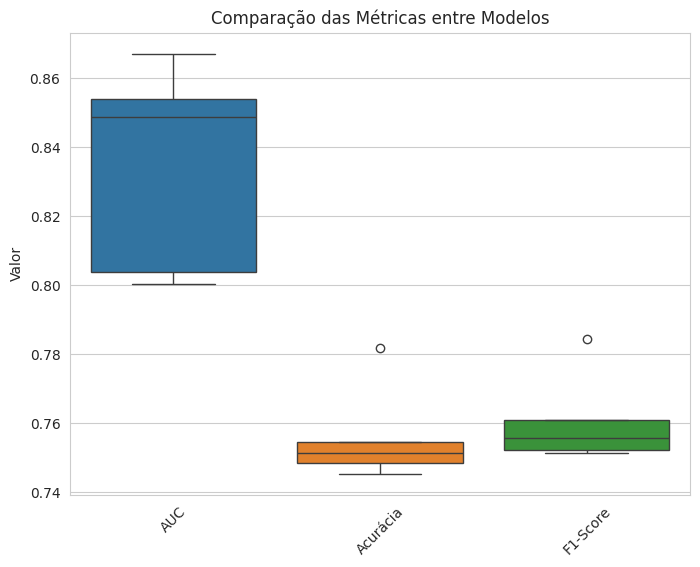

In [ ]:
metrics_df = pd.DataFrame({
    "Modelo": list(models.keys()),
    "AUC": [results[model]['AUC_Teste'] for model in models],
    "Acurácia": [results[model]['Acurácia_Teste'] for model in models],
    "F1-Score": [results[model]['F1-Score_Teste'] for model in models]
}).set_index("Modelo")

plt.figure(figsize=(8, 6))
sns.boxplot(data=metrics_df)
plt.xticks(rotation=45)
plt.title("Comparação das Métricas entre Modelos")
plt.ylabel("Valor")
plt.show()
